Unless denoted otherwise, all functions and code were created by Pepijn van den Berg.

In [5]:
import scipy.io
import io
from data_loader import DataLoader
import numpy as np
from utils import *
from matplotlib import pyplot as plt
import numpy.random as rng

In [6]:
def load_data(rats):
    return DataLoader('C:\\Users\\pepij\\OneDrive\\Documenten\\02 AI\\4 Thesis\\GG-Dataset-Tulio-Ultralight\\' , 'BLA', rats=[rats])

In [7]:
def session_vars(session_nr):
    """
    This function finds the following session-specific variables:
        neuron_list: a list of all neuron numbers
        n_neurons:   the total number of neurons
        session:     the session code
        begin_run_t: at what time the run-component of the session starts
        end_run_t:   at what time the run-component of the session ends        
    """
    session = list(data.events[rat].keys())[session_nr]
    neuron_list = list(spk[rat][session][area].keys())
    n_neurons = len(neuron_list)

    begin_run_i = list(data.events[rat][session]['cat']['data']).index('beginning run')
    end_run_i = list(data.events[rat][session]['cat']['data']).index('end run')

    begin_run_t = list(data.events[rat][session]['cat']['ts'])[begin_run_i]
    end_run_t = list(data.events[rat][session]['cat']['ts'])[end_run_i]
    
    return neuron_list, n_neurons, session, begin_run_t, end_run_t

In [8]:
def position_vars(visualization=False):
    """"
    This function finds two variables related to position of the rat:
        x:        the x coordinate of the rat
        y:        the y coordinate of the rat
        time_loc: the series of locations with their corresponding times
        x_mean:   the mean x-coordinate of the rat during a puff
        puff_locs_x: used for visualization. x locations of puffs
        puff_locs_y: used for visualization. y locations of puffs
    """
    x = data.position[rat][session]['x']
    y = data.position[rat][session]['y']
    time_loc = data.position[rat][session]['Time']

    # Cut x and y to the run session. 
    loc_run_ind = [index for index, t in enumerate(time_loc) if t > begin_run_t and t < end_run_t]
    
    x_cut = x[loc_run_ind[0]:loc_run_ind[-1]]
    y_cut = y[loc_run_ind[0]:loc_run_ind[-1]]
    
    # Find the puff events and location
    puff_events_ = data.events[rat][session]['puf']['ts']
    puff_events = []
    
    # Make sure the puff events are an int format (some sessions consist of strings)
    if isinstance(list(puff_events_)[0], str):
        for t in np.array(puff_events_):
            puff_events.append(float(t[:14]))
    else:
        puff_events = puff_events_
    
    
    # Filter puff events to run session
    puff_events = [t for t in puff_events if t > begin_run_t and t < end_run_t]
    
    
    puff_locs_x = [x_cut[np.absolute(time_loc-i).argmin()] for i in puff_events]
    puff_locs_y = [y_cut[np.absolute(time_loc-i).argmin()] for i in puff_events]

    # Find the mean of the puff location
    x_mean = np.mean(puff_locs_x)

    if(visualization):
        plt.figure(figsize = (12,12))
        plt.subplot(2, 2, 1)
        plt.plot(x_cut,y_cut)
        plt.plot(puff_locs_x, puff_locs_y, 'o', label = 'puff locations')
        ylimits = plt.ylim()
        plt.vlines(x = x_mean, ymin=ylimits[0], ymax= ylimits[1],linestyle='--', color='black', label = 'mean puff location')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(x_cut, time_loc[loc_run_ind[0]:loc_run_ind[-1]])
        plt.plot(puff_locs_x, puff_events, 'o', label = 'puff locations')
        
        plt.subplot(2, 2, 3)
        plt.hist(puff_locs_x, density=True)
        ylim = plt.ylim()
        plt.vlines(x_mean,ymin=0, ymax=ylim[1],color='red', label = 'mean')
        plt.legend()        
        plt.show()
    
    return x, y, time_loc, x_mean, puff_locs_x, puff_locs_y, x_cut, y_cut

In [9]:
def spike_matrix_init(window, bin_width, visualization = False):
    """
    This function constructs a spike matrix of shape [trial x neuron x bin]. 
    Every trial consists of an airpuff event, or the crossing of the location of an airpuff event.
    Together with the matrix, a vector is returned that labels each trial as a puff/safe trial.
    """
    # Find all reward timings of the session
    lrw_ts_ = list(data.events[rat][session]['lrw']['ts']) 
    rrw_ts_ = list(data.events[rat][session]['rrw']['ts']) 
    
    lrw_ts = []
    rrw_ts = []
    
    # Make sure the rewards are an int format (some sessions consist of strings)
    if isinstance(rrw_ts_[0], str):
        for t in np.array(rrw_ts_):
            rrw_ts.append(float(t[:14]))
    else:
        rrw_ts = rrw_ts_
    
    if isinstance(lrw_ts_[0], str):
        for t in np.array(lrw_ts_):
            lrw_ts.append(float(t[:14]))
    else:
        lrw_ts = lrw_ts_

    # Cut off the left- and right rewards to the run-session
    rrw_ts = [t for t in rrw_ts if t > begin_run_t and t < end_run_t]
    lrw_ts = [t for t in lrw_ts if t > begin_run_t and t < end_run_t]

    # Concatenate all reward timings
    rw_ts = np.sort(rrw_ts + lrw_ts)

    # Create bins 
    bins = np.arange(window[0],window[1]+1,bin_width)

    # Initialize the spike matrix
    spk_matrix_ = np.zeros([len(rw_ts)-1,n_neurons,bins.shape[0]-1]) # dimensions: trial x neuron x bins

    # Initialize the trial type vector
    trial_type = np.ndarray(len(rw_ts)-1)

    # Keep track of event locations, only used for visualization
    nopuff_x = []
    nopuff_y = []
    puff_x = []
    puff_y = []
    
    # Keep track of the most recent puff
    last_puff_x = x_mean 
    
    # Keep track of all event times (only for visualization)
    event_ts_puff = []
    event_ts_safe = []
    
    for reward_i, reward_t in enumerate(rw_ts[:-1]):  # Every reward except the last marks the start of a run
        # Make a list of puffs in the trial, if any
        puff_list = [t for t in data.events[rat][session]['puf']['ts'] if t > reward_t and t < rw_ts[reward_i+1]]

        valid_trial = True
        
        # Check whether this is a puff trial
        if np.any(puff_list):
            event_t = puff_list[-1]
            event_ts_puff.append(event_t)
            
            # update last puff variable
            last_puff_x = x[np.absolute(time_loc-event_t).argmin()]
            puff_x.append(last_puff_x)
            puff_y.append(y[np.absolute(time_loc-event_t).argmin()])

        else: # If in a no-puff trial:
            # Take a time slice of the trial 
            time_loc_ind = [index for index, t in enumerate(time_loc) if t > reward_t and t < rw_ts[reward_i+1]]
            
            # Check whether the timepoints give an empty array 
            if(~np.any(np.array(time_loc_ind))):
                valid_trial = False
                continue
            
            # Cut x, y and t to the trial
            x_trial = list(x[time_loc_ind[0]:time_loc_ind[-1]])
            y_trial = list(y[time_loc_ind[0]:time_loc_ind[-1]])
            time_loc_trial = list(time_loc)[time_loc_ind[0]:time_loc_ind[-1]]           
            
            # Find the t where the rat is the closest to the recent puff location
            if len(np.array(x_trial))==0: # Some sessions have missing location data. This prevents an error
                   event_t = 0
            else:
                event_t = time_loc_trial[np.absolute(np.array(x_trial)-last_puff_x).argmin()]
            event_ts_safe.append(event_t)
            
            if(visualization):
                nopuff_x.append(x_trial[np.absolute(np.array(x_trial)-last_puff_x).argmin()]) 
                nopuff_y.append(y_trial[np.absolute(np.array(x_trial)-last_puff_x).argmin()]) 
        
        if(valid_trial):
            for ineuron in range(n_neurons):
                spikes = spk[rat][session][area][neuron_list[ineuron]]
                idx = np.where(np.logical_and(spikes>event_t+window[0], spikes<event_t+window[1]))[0]
                count = np.histogram(spikes[idx]-event_t,bins)
                spk_matrix_[reward_i,ineuron] = count[0]
        else:
            spk_matrix_[reward_i,ineuron] = np.zeros(len(range(window[0], window[1]+1)))
                

        # Put a 1 if in a puff trial, and a 0 otherwise
        trial_type[reward_i] = int(np.any(puff_list))

    if(visualization):   
        plt.figure(figsize = (10,5))
        plt.plot(x_cut, y_cut)
        plt.plot(puff_x, puff_y, 'o', markersize=3, color='r', label = 'puff locations')
        plt.plot(nopuff_x, nopuff_y, 'o', markersize=3, color='lime', label = 'non-puff locations')
        ylimits = plt.ylim()
        plt.vlines(x = x_mean, ymin=ylimits[0], ymax= ylimits[1],linestyle='--', color='black', label = 'mean puff location')
        plt.legend()
        plt.savefig('Figure8a.svg')
        plt.savefig('Figure8a.jpg')
        plt.show()
        #plt.figure()
        #plt.title('All spikes in the session, timelocked at puff/no puff')
        #plt.imshow(np.sum(spk_matrix_,axis=0),aspect='auto',cmap='gray_r', vmin=0, vmax=1)
        #plt.xticks(range(0, spk_matrix_.shape[2], 200), range(window[0],window[1], 200))
        #plt.xlabel('Time (ms)')
        #plt.ylabel('Neuron')
        #plt.vlines(x = window[1], ymin=0, ymax= spk_matrix_.shape[1],linestyle='--', color='black', alpha=0.5)
        
        plt.show()
        
        plt.figure(figsize = (10,10))
        plt.plot(x, time_loc)
        plt.plot(puff_x, event_ts_puff, 'o', color='r',label='Puff events')
        plt.plot(nopuff_x, event_ts_safe, 'o', color='lime', label='Safe events')
        plt.ylim([10250000, 10900000])
        plt.xlabel('x')
        plt.ylabel('time (ms)')
        plt.savefig('Figure8b.svg')
        plt.savefig('Figure8b.jpg')
        plt.show()

    return spk_matrix_, trial_type

In [10]:
def spk_triggered(spk_matrix, fr_window):
     """
    Returns the data where each individual spike is segmented to a time-locked trial surrounding that spike.
    Also, we output the trial labels (which neuron was timelocked at this particular trial/row).
    
    input:
    - spk_matrix : the binned spike data
    - fr_window  : half of the width of the segmented window, in ms.
    output:
    - spk_triggered_data : the spike data, segmented to slices, timelocked at each spike
    - trial_labels       : a vector describing at the nth element to which neuron the spike belongs that is timelocked in the nth row of spk_triggered. 
    """
    spk_triggered_data = [] 
    trial_labels = []
    nbins = 2*fr_window+1
    # For each neuron
    for ineuron in range(spk_matrix.shape[1]):
        rank_matrix = [] # will store all ranks for all spikes in all trials
        for itrial in range(spk_matrix.shape[0]):
            idx = np.where(spk_matrix[itrial,ineuron,:]>0)[0]
            # For every timepoint where the neuron spikes
            for t in idx:
                # Make window surrounding the spike
                spk_window = np.arange(max(t-fr_window, 0),min(t+fr_window+1, spk_matrix.shape[2]))            
                spikes_slice = spk_matrix[itrial]
                spikes_slice = spikes_slice[:,spk_window]

                # If window is of correct size (not at the edges)
                if spikes_slice.shape[1]==nbins:
                    spk_triggered_data.append(spikes_slice)
                    trial_labels.append(ineuron)
    return np.array(spk_triggered_data), trial_labels

In [11]:
def mask_spikes(puff = True):
    """
    This function returns the spike matrix for only the trials that are puff (or no puff if puff = False)
    """
    PUFF = 1
    SAFE = 0

    puff_idx = np.where(trial_type == PUFF)[0]
    safe_idx = np.where(trial_type == SAFE)[0]
   
    if puff:
        return spk_matrix_[puff_idx,:,:]
    else:
        return spk_matrix_[safe_idx,:,:]

In [12]:
def firing_ranks_spkmatrix(spikes_slice, trigger_neuron):
    """
    Computes the ranks (i.e., the order in which the neurons spiked) of the given data, where the timelocked spike receives rank 0.
    Input: 
    - spikes_slice   : the spike data
    - trigger_neuron : the neuron whose spike is being timelocked.
    Output:
    - ranks          : the neurons, sorted on their ranks.
    """
    
    # Make a vector for average spike times per neuron
    avg_spike = np.zeros([spikes_slice.shape[1]])
    
    # Make a matrix of ranks for each trial
    ranks = np.full([spikes_slice.shape[0], spikes_slice.shape[1]*2+1], np.nan)

    for trial in range(spikes_slice.shape[0]):    
        # Find average spiking time per neuron
        for ineuron in range(spikes_slice.shape[1]):
            avg_spike[ineuron] = np.mean([bin_idx for bin_idx, activity in enumerate(spikes_slice[trial, ineuron]) if activity > 0])
        
        # Sort the neurons, based on their avg spiking time
        sorted_neurons = np.argsort(avg_spike)

        # Find rank of the trigger neuron
        base_rank = np.nonzero(sorted_neurons==trigger_neuron)[0]
        
        
        # Fill the rank matrix, but only for the defined 'rank-slots'
        for ineuron, neuron in enumerate(sorted_neurons):
            if not np.isnan(avg_spike[neuron]):
                ranks[trial,ineuron+spikes_slice.shape[1]-base_rank] = neuron 
    return ranks

In [13]:
def firing_ranks2occ_matrix(firing_ranks):
    """
    Function made by Tom Has.
    Constructs an occurrence matrix from firing ranks where occ[x, y] represents how often neuron x had rank y.
    Input:  - firing_ranks: Array containing for each rank in each trial which neuron had this rank in this trial
    Output: - occ:          Occurrence matrix
    """
    n_neurons = firing_ranks.shape[1]
    occ = np.zeros((n_neurons, n_neurons), dtype=int)
    # Loop over trials
    for trial in firing_ranks:
        # Loop over ranks:
        for rank, neuron in enumerate(trial):
            if np.isnan(neuron):
                continue
            # For not nan rank, neuron pairs, increment the respective square in the occurrence matrix|
            occ[int(neuron), rank] += 1
    return occ

In [14]:
def sort_occ_matrix(occ_matrix, mean_rank=False):   
    """"
    Modifies an occ matrix to only active neurons and 'used' rank positions. 
    Also, it sorts the matrix, either based on mean rank, or on mode rank.
    """
    # Find active neurons
    active_neurons = np.where(np.any(occ_matrix>0, axis=1))[0]

    # Find non-zero rank range
    active_ranks = np.where(np.any(occ_matrix!=0, axis=0))[0]
    if len(active_ranks)<=1:
        rank_limit_1 = 1
        rank_limit_2 = 2
    else:
        rank_limit_1 = active_ranks[1]
        rank_limit_2 = active_ranks[-1]

    # Pick 'active' rows of occ_matrix, for relevant rank range
    occ_matrix = occ_matrix[active_neurons, rank_limit_1:rank_limit_2+1]
    
    # Compute max rank
    max_ranks = np.argmax(occ_matrix, axis=1)
    
    # Compute mean rank
    mean_ranks = np.zeros(len(active_neurons))
    for ineuron, neuron in enumerate(active_neurons):
        mean_ranks[ineuron] = np.mean(occ_matrix[ineuron,:]*np.arange(rank_limit_1, rank_limit_2+1))
    
    
    # Return sorted occ matrix
    if mean_rank:
        return [occ_matrix[np.argsort(mean_ranks),:], np.argsort(mean_ranks), active_neurons]
    else:
        return [occ_matrix[np.argsort(max_ranks),:], np.argsort(max_ranks), active_neurons]

In [15]:
def aligned_firing_ranks2occ_matrix(firing_ranks):
    """
    Function made by Tom Has.
    Constructs an occurrence matrix from firing ranks where occ[x, y] represents how often neuron x had rank y.
    Intended for relative ranks use case.
    Input:  - firing_ranks: Array containing for each rank in each trial which neuron had this rank in this trial
    Output: - occ:          Occurrence matrix
    """
    n_neurons = int((firing_ranks.shape[1]+1)/2)
    occ = np.zeros((n_neurons, n_neurons*2-2), dtype=int)
    # Loop over trials
    for trial in firing_ranks:
        # Loop over ranks:
        for rank, neuron in enumerate(trial):
            if np.isnan(neuron) or rank == n_neurons-1:
                continue
            # For not nan rank, neuron pairs, increment the respective square in the occurrence matrix
            if rank > n_neurons-1:
                occ[int(neuron), rank-1] += 1
            else:
                occ[int(neuron), rank] += 1
    return occ

In [16]:
def MI(M):
    """
    Function made by Tom Has.
    Calculates the mutual information between the 2 axes of a matrix.
    Input:  - M:  2d matrix
    Output: - MI: Mutual information
    """
    sizex = M.shape[0]
    sizey = M.shape[1]
    total = np.sum(M)
    p_Y = np.sum(M, axis=0) / total
    p_X = np.sum(M, axis=1) / total
    # MI = sum over x and y: p(x,y) * log(p(x,y) / (p(x) * p(y)))
    #    = sum over x and y: M(x,y)/total * log((M(x,y) * total) / (p_X(x) * p_Y(y)))
    MI = sum([sum([(
        0 if M[x, y] == 0 else
        M[x, y] / total * np.log((M[x, y] / total) / (p_X[x] * p_Y[y]))
    ) for x in range(sizex)]) for y in range(sizey)])
    return MI

In [17]:
def spikes_in_window(spikes, window_start, window_end):
    """
    Function made by Tom Has.
    """
    return [spike for spike in spikes if spike > window_start and spike < window_end]

cut_spikes = np.vectorize(spikes_in_window, otypes=[object])
vec_mean = np.vectorize(np.mean)
len_vec = np.vectorize(len)

In [18]:
def surrogate_occ_alt(firing_times_per_trial, window=(-50, 50)):
    """
    Function originally made by Tom Has, but modified by Pepijn van den Berg to function correctly for spike data that is 
    represented in time-bins instead of spiking times.
    """
    # Pick random spike
    spk = rng.choice(np.nonzero(firing_times_per_trial.flatten() == 1)[0])  
    trial = np.unravel_index(spk, firing_times_per_trial.shape)[0]
    align_to = np.unravel_index(spk, firing_times_per_trial.shape)[1]
    spike_time = np.unravel_index(spk, firing_times_per_trial.shape)[2]

    relevant_spikes = firing_times_per_trial[trial,:, int(spike_time+window[0]):int(spike_time+window[1])]

    ranks = firing_ranks_spkmatrix(np.reshape(relevant_spikes, [1,relevant_spikes.shape[0], relevant_spikes.shape[1]]), align_to)
    
    return aligned_firing_ranks2occ_matrix(ranks)

In [19]:
def get_URI_nontimelocked(spk_matrix, nr_surrogates, window=(-50, 50)):
    """
    Function made by Tom Has, but modified by Pepijn van den Berg to function correctly for spike data that is 
    represented in time-bins instead of spiking times.
    
    Computes the mutual information between unit and firing rank after aligning windows at spikes of every neuron, per neuron.
    Firing rank is defined as the place in the order of average firing times for a neuron within a trial.
    Input:  - spk_matrix: 2d array containing for each trial, for each neuron the list of firing times
                                      that this neuron produced in this trial.
            - nr_surrogates:          Number of shuffled occurrence matrices to compute p-value. Gets more accurate
                                      with higher numbers.
            - window:                 tuple containing the start and end of the window set around each spike.
    Output: - URI:                    The calculated URI metric.
            - occurrence_matrix:      The occurrence matrix between neuron and rank
            - p-value:                p-value from surrogate calculation. Can be interpreted as the probability of
                                      URI metric being as high as it is under null-hypothesis (no sequence).
    """
    n_neurons = spk_matrix.shape[1]
    URIs = np.zeros(n_neurons)
    nr_windows = np.zeros(n_neurons, dtype=int)

    triggered_spk_matrix, trial_labels = spk_triggered(spk_matrix[:,:,1000:3000], int(seq_length*1000))

    inactive_neurons = []
    
    for neuron in range(n_neurons):
        triggered_spk_matrix_ = triggered_spk_matrix[np.where(np.array(trial_labels)==neuron)[0]]
        nr_windows[neuron] = len(triggered_spk_matrix_)
        if len(triggered_spk_matrix_) <= 5: # With less than 5 spikes, the URI will be set to 0.
            inactive_neurons.append(neuron)
            URI_val = 0
        else:
            firing_ranks = firing_ranks_spkmatrix(triggered_spk_matrix_, neuron)
            occ_matrix = aligned_firing_ranks2occ_matrix(firing_ranks)                
            URI_val = MI(occ_matrix)
        URIs[neuron] = URI_val
    
    max_nr_windows = np.max(nr_windows)
    surrogate_stronger = np.zeros(n_neurons, dtype=int)

    for surrogate in range(nr_surrogates):
        surr_occ = [surrogate_occ_alt(spk_matrix, window=window) for _ in range(int(max_nr_windows))]
        
        for neuron in range(n_neurons):
            if neuron in inactive_neurons:
                surr_URI = 0
            else:
                surr_URI = MI(np.sum(surr_occ[:nr_windows[neuron]], axis=0))

            if surr_URI >= URIs[neuron]:
                surrogate_stronger[neuron] += 1
    URI_p_vals = surrogate_stronger / nr_surrogates
    return URIs, URI_p_vals

# ------------------------------------------------------------------------------------

# Construct a session matrix with all valid sessions

In [20]:
rats = ['Rat08', 'Rat09', 'Rat10', 'Rat11']

# Initialize all sessions for all rats
valid_sessions = [list(range(9)), list(range(10)), list(range(12)), list(range(8))]

# Remove all invalid sessions. 
#Sessions are invalid if there is a missing file, or if there are not sufficiently many airpuffs/valid trials.
valid_sessions[1].remove(4)
valid_sessions[2].remove(1)
valid_sessions[2].remove(10)
valid_sessions[2].remove(11)

# Initialize a session matrix of dimensions [rat x session]
session_matrix = np.full([4, 12],np.nan)
for irat in range(4):
    session_matrix[irat,:len(valid_sessions[irat])] = valid_sessions[irat]
    
session_matrix

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8., nan, nan, nan],
       [ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., nan, nan, nan],
       [ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., nan, nan, nan],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7., nan, nan, nan, nan]])

# Set up hyperparameters

In [21]:
window = (-1000, 1000)
seq_length=0.05
# Width of the bins used in the spike matrix
bin_width = 1

# Define the sequence-window and number of surrogates
n_surrogates = 200

area = 'all'

# Testing significance

In [18]:
v = False

# We construct a matrix for all p-values, with dimensions: [rat x session x  puff/safe]
p = np.full([4, 12, 2, 150], np.nan)
URIs_matrix = np.full([4, 12, 2, 150], np.nan)

rats = ['Rat08', 'Rat09', 'Rat10', 'Rat11']

puff_ = [True, False]

for irat, rat in enumerate(rats):
    print("Rat:", str(irat))
    # Load the (spike) data
    data = load_data(rat)
    spk = data.get_spk()
    
    
    for session_nr in session_matrix[irat]:
        if np.isnan(session_nr):
            continue
        print("    Session:", str(int(session_nr)))
        
        session_nr = int(session_nr)

        # Define neurons, session and times of the run
        neuron_list, n_neurons, session, begin_run_t, end_run_t = session_vars(session_nr)

        # Define variables related to the location of the rats and airpuff events
        x, y, time_loc, x_mean, puff_locs_x, puff_locs_y, x_cut, y_cut = position_vars(visualization = v)

        # Construct the spike matrix 
        spk_matrix_, trial_type = spike_matrix_init(window, bin_width, visualization = v)   

        # For both puff and no puff 
        for ipuff in range(2):
            print("        ", str(puff_[ipuff]))
            # Mask the spike matrix to the events
            spk_matrix = mask_spikes(puff=puff_[ipuff])
            
            URIs, URI_p_vals = get_URI_nontimelocked(spk_matrix, n_surrogates, window=(-50, 50))

            p[irat,session_nr, ipuff, :spk_matrix.shape[1]] = URI_p_vals
            URIs_matrix[irat,session_nr, ipuff, :spk_matrix.shape[1]] = URIs
            print(URI_p_vals)

Rat: 1
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

    Session: 0
         True


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[0.225  1.     1.     1.     1.     1.     0.8875 1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     0.4    1.     0.6875 0.325  0.675  1.     0.8875 1.     1.
 0.7375 0.3125 0.5375]
         False
[0.65   1.     0.375  1.     1.     1.     0.925  1.     1.     1.
 1.     1.     1.     1.     1.     0.1125 0.5    1.     1.     1.
 1.     1.     0.3    1.     0.375  0.1125 1.     0.075  1.     1.
 1.     0.85   1.    ]
    Session: 1
         True
[1.     1.     1.     1.     1.     1.     0.9875 1.     0.8    0.6375
 1.     1.     0.775  1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     0.825
 1.     0.8875 1.     1.     1.     0.8125 1.     0.8125 1.     0.9125]
         False
[1.     1.     1.     1.     1.     1.     0.825  1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     0.96

C:\Users\pepij\AppData\Local\Temp\ipykernel_10628\891461473.py:10: RuntimeWarning: invalid value encountered in divide
  p_Y = np.sum(M, axis=0) / total
C:\Users\pepij\AppData\Local\Temp\ipykernel_10628\891461473.py:11: RuntimeWarning: invalid value encountered in divide
  p_X = np.sum(M, axis=1) / total


[1.    1.    1.    1.    1.    1.    0.975 1.    1.    1.    0.375]
         False
[1.     1.     0.175  0.325  0.8    1.     0.525  0.8625 0.6375 1.
 0.875 ]
Rat: 2
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:515: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat10\Rat10-20140704\Rat10-20140704-pos.csv
  self.__warning_msg(self.paths[rat][session]['position'])


    Session: 0
         True


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\pepij\AppData\Local\Temp\ipykernel_10628\891461473.py:10: RuntimeWarning: invalid value encountered in divide
  p_Y = np.sum(M, axis=0) / total
C:\Users\pepij\AppData\Local\Temp\ipykernel_10628\891461473.py:11: RuntimeWarning: invalid value encountered in divide
  p_X = np.sum(M, axis=1) / total


[1. 1. 1. 1. 1.]
         False
[1. 1. 1. 1. 1.]
    Session: 2
         True
[1.     0.225  1.     1.     0.6375 1.     0.8625 1.     1.     0.225
 1.     0.6875 1.     1.     1.     1.     0.525  1.     1.     1.
 1.     0.6625 1.     1.     0.125  1.     1.     0.7875 1.    ]
         False
[1.     0.75   1.     1.     0.8    1.     0.875  1.     1.     0.8875
 1.     1.     1.     1.     1.     1.     0.825  1.     0.9375 1.
 1.     1.     1.     1.     1.     1.     1.     0.525  1.    ]
    Session: 3
         True
[1.     1.     1.     0.6375 1.     1.     0.5625 1.     1.     1.
 1.     1.     1.     1.     0.9875 1.     0.025  1.     1.     1.
 1.     0.9375 1.     1.     1.     1.     0.05   0.8    1.     1.
 1.     1.     1.     0.6    1.     1.    ]
         False
[1.     1.     1.     0.6875 1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     0.525  1.     0.925  1.     1.     1.
 1.     0.9625 1.     1.     1.     1.     0.6    0.725  1.     1.
 1.     0.33

C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[0.375  1.     1.     1.     1.     0.7625 1.     1.     1.     0.625
 0.4375 0.2625 1.     1.     1.     1.     1.     0.25   1.     0.9625
 1.     1.     1.     0.8625 1.     1.     1.     0.    ]
         False
[0.5625 0.65   1.     1.     0.0125 0.7625 1.     1.     0.3375 0.825
 0.125  0.8375 1.     1.     1.     1.     1.     0.0625 1.     1.
 1.     0.8125 1.     1.     0.875  1.     1.     0.05  ]
    Session: 1
         True
[1.     0.825  0.15   1.     0.5625 1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     0.8625 1.     1.
 1.     1.     0.425  0.325  1.     1.     1.     1.     1.     0.725
 1.     1.     1.     0.8125 1.     1.     1.     1.     1.     0.9375
 1.     0.675  1.     0.8    1.     1.     1.     1.     0.0375 0.1875
 1.     0.175  0.675  1.     1.     1.    ]
         False
[1.     0.5875 0.25   1.     0.3    1.     1.     1.     1.     1.
 1.     0.9    1.     1.     1.     1.     1.     0.9625 1.     1.
 0.5    0.475  1.     0

In [21]:
significant_sessions = []
significant_neurons = []

for irat, rat in enumerate(rats):
    for session_nr in session_matrix[irat]:
        if np.isnan(session_nr):
            continue
        for ipuff in range(2):
            if len(np.argwhere(p[irat,int(session_nr), ipuff]<=0.05))>0:

                significant_sessions.append([rat, int(session_nr), ipuff])
                significant_neurons.append(np.argwhere(p[irat,int(session_nr), ipuff]<=0.05))
                
                

In [25]:
for i in range(len(significant_sessions)):
    print(significant_sessions[i])
    print(significant_neurons[i])
    print()

['Rat09', 2, 1]
[[47]]

['Rat09', 3, 0]
[[ 8]
 [38]
 [40]
 [91]]

['Rat09', 3, 1]
[[18]
 [28]
 [34]
 [44]
 [78]]

['Rat09', 6, 0]
[[ 0]
 [41]
 [61]]

['Rat09', 6, 1]
[[41]]

['Rat09', 7, 0]
[[ 2]
 [39]]

['Rat09', 7, 1]
[[12]]

['Rat09', 8, 0]
[[ 0]
 [13]
 [14]
 [32]
 [35]]

['Rat09', 8, 1]
[[ 6]
 [12]
 [13]]

['Rat10', 3, 0]
[[16]
 [26]]

['Rat10', 4, 1]
[[ 5]
 [15]]

['Rat10', 6, 0]
[[26]]

['Rat10', 6, 1]
[[11]]

['Rat11', 0, 0]
[[27]]

['Rat11', 0, 1]
[[ 4]
 [27]]

['Rat11', 1, 0]
[[48]]

['Rat11', 1, 1]
[[43]]

['Rat11', 2, 0]
[[27]]

['Rat11', 2, 1]
[[ 1]
 [11]
 [43]
 [56]
 [82]
 [90]]

['Rat11', 3, 0]
[[ 0]
 [37]
 [58]
 [69]]

['Rat11', 3, 1]
[[  3]
 [ 12]
 [ 69]
 [ 75]
 [104]]

['Rat11', 4, 0]
[[ 16]
 [ 17]
 [ 27]
 [ 42]
 [ 95]
 [102]
 [110]]

['Rat11', 4, 1]
[[ 4]
 [12]
 [27]
 [89]]

['Rat11', 5, 0]
[[14]
 [39]
 [55]]



In [21]:
significant_sessions = []
significant_sessions.append([0, 5, [50]])
significant_sessions.append([0, 6, [28]])
significant_sessions.append([0, 8, [4, 21]])
significant_sessions.append([1, 3, [8, 38, 40, 91]])
significant_sessions.append([1, 6, [0, 41, 61]])
significant_sessions.append([1, 7, [2, 39]])
significant_sessions.append([1, 8, [0, 13, 14, 32, 35]])
significant_sessions.append([2, 3, [16, 26]])
significant_sessions.append([2, 6, [26]])
significant_sessions.append([3, 0, [27]])
significant_sessions.append([3, 1, [48]])
significant_sessions.append([3, 2, [27]])
significant_sessions.append([3, 3, [0, 37, 58, 69]])
significant_sessions.append([3, 4, [16, 17, 27, 42, 95, 102, 110]])
significant_sessions.append([3, 5, [14, 39, 55]])


In [22]:
significant_sessions

[[0, 5, [50]],
 [0, 6, [28]],
 [0, 8, [4, 21]],
 [1, 3, [8, 38, 40, 91]],
 [1, 6, [0, 41, 61]],
 [1, 7, [2, 39]],
 [1, 8, [0, 13, 14, 32, 35]],
 [2, 3, [16, 26]],
 [2, 6, [26]],
 [3, 0, [27]],
 [3, 1, [48]],
 [3, 2, [27]],
 [3, 3, [0, 37, 58, 69]],
 [3, 4, [16, 17, 27, 42, 95, 102, 110]],
 [3, 5, [14, 39, 55]]]

# Retrieving sequences for all significant neurons

In [18]:
def MI_decrease(ranks, neurons):
    """
    Calculates all the MIs after pruning each neuron individually.
    Input: 
    - ranks           : the ranks of all the trials
    - neurons         : a list of all neurons

    Output:
    - MIs_sorted      : all MIs after pruning, sorted
    - neurons_sorted  : all neurons, sorted on their MI after pruning
    """
    # Calculate MI before pruning
    baseline_MI = MI(firing_ranks2occ_matrix(ranks))
    
    MIs = np.zeros(len(neurons))
    
    # Prune each neuron individually from the original ranks and calculate MI
    for ineuron, neuron in enumerate(neurons):
        ranks_candidate, MI_candidate = cut_ranks(ranks, neuron)
        MIs[ineuron] = MI_candidate

    # Sort the MIs based on their decrease
    MIs_sorted = baseline_MI - np.sort(MIs)

    # Sort the neurons according to their decrease  (larger decreases resemble a higher likelihood to be part of the sequence)
    neurons_sorted = np.array(neurons)[np.argsort(MIs)]
    return MIs_sorted, neurons_sorted

def construct_sequence(ranks, n_neurons, n_surrogates, threshold=0.05, mode="max", max_neurons=10): 
"""
    Constructs the sequence, by filtering out insignificant neurons and subsequently ordering on either the mean or mode rank.
    Input:
    - ranks          :  the ranks of all the trials.
    - n_neurons      :  the total number of neurons in the data.
    - n_surrogates   :  the number of surrogates used for testing significance of individual neurons
    - threshold      :  value between 0 and 1. used for significance testing and can be interpreted as the p-value.
    - mode           :  either "mean" or "max". decides how the significant neurons are ordered to find sequence order.
    - max_neurons    :  the maximum sequence length. 

    Output:
    - sequence             :  a list containing the ordered sequence
    """

    # Find MIs with the largest decrease after pruning the neurons individually
    MIs, seq_neurons = MI_decrease(ranks, range(n_neurons))
    MIs = MIs[:max_neurons]
    seq_neurons = seq_neurons[:max_neurons]
    
    MIs_surrogate = np.zeros([n_surrogates, max_neurons])

    # Keep track of total number of surrogates that have a larger MI decrease after pruning the x'th most significant neuron
    for s in range(n_surrogates):
        for ineuron in range(max_neurons):
            #print(seq_neurons[ineuron])
            surrogate = surrogate_ranks(ranks, seq_neurons[ineuron])
            occ = firing_ranks2occ_matrix(surrogate)
            #plt.figure()
            #plt.imshow(sort_occ_matrix(occ)[0], aspect='auto')
            #plt.yticks(range(sort_occ_matrix(occ)[0].shape[0]), sort_occ_matrix(occ)[2][sort_occ_matrix(occ)[1]])
            #plt.show()

            MIs_surrogate[s, ineuron] = MI(firing_ranks2occ_matrix(surrogate)) - cut_ranks(surrogate, seq_neurons[ineuron])[1]

    insignificant = np.array([np.count_nonzero(MIs_surrogate[:,ineuron]>=MIs[ineuron])/n_surrogates > threshold for ineuron in range(max_neurons)], dtype=int)
    ratios = [np.count_nonzero(MIs_surrogate[:,ineuron]>=MIs[ineuron])/n_surrogates for ineuron in range(max_neurons)]
    
    if len(np.where(insignificant==0)[0])>0:
        seq_neurons = seq_neurons[np.where(insignificant==0)[0]]
    else:
        seq_neurons = seq_neurons[:3]
    
    
    occ_matrix = firing_ranks2occ_matrix(ranks)
    
    # Compute mean and maximum ranks
    mean_ranks = np.zeros(len(seq_neurons))
    max_ranks = np.zeros(len(seq_neurons))
    for ineuron, neuron in enumerate(seq_neurons):        
        mean_ranks[ineuron] = np.mean(occ_matrix[neuron,:]*np.arange(occ_matrix.shape[1]))
        max_ranks[ineuron] = np.argmax(occ_matrix[neuron,:])

    # Sort the sequence neurons
    if mode == "mean":
        sequence = np.array(seq_neurons)[np.argsort(mean_ranks)]
    else: 
        sequence = np.array(seq_neurons)[np.argsort(max_ranks)]

    # Create the template
    template = np.zeros([occ_matrix.shape[0], occ_matrix.shape[0]])

    for rank, neuron in enumerate(sequence):
        template[neuron, rank] = 1

    # Create the null-template
    null_template = np.zeros([occ_matrix.shape[0], occ_matrix.shape[0]])
    null_template[sequence,:len(sequence)] = 1/len(sequence)

    return sequence, template, null_template, MIs, MIs_surrogate, ratios

def cut_ranks(ranks, neuron):
    """
    Cuts all entries of the neuron out of the ranks. Also, the MI after cutting is outputted.
    """
    pruned_ranks = np.zeros([ranks.shape[0], ranks.shape[1]])
    for itrial in range(ranks.shape[0]):
        trial = list(ranks[itrial])
        if neuron in trial:
            trial.remove(neuron)
            trial.append(np.nan)
        pruned_ranks[itrial] = trial    
    return pruned_ranks, MI(firing_ranks2occ_matrix(pruned_ranks))

def surrogate_ranks(firing_ranks, neuron): 
    """
    Surrogate ranks are created by randomly shuffling the ranks of all spikes of the given neuron. 
    The sequential information of all other neurons remain untouched.
    """
    ranks = np.zeros([firing_ranks.shape[0], firing_ranks.shape[1]])
    
    for itrial, trial in enumerate(firing_ranks):
        if np.any(trial==neuron):
            trial_list = list(trial)
            spike_indices = np.sort(np.where(trial==neuron)[0],)[::-1]
            
            for spike_idx in spike_indices:
                trial_list.pop(spike_idx)      
            for spk in range(len(spike_indices)):
                ivalid = np.where(~np.isnan(trial))[0]
                n_slots = len(ivalid)+1
                new_rank = np.random.randint(n_slots)
                trial_list.insert(new_rank, neuron)
            ranks[itrial,:] = np.array(trial_list)
        else:
            ranks[itrial,:] = firing_ranks[itrial]
    return ranks

In [23]:
rats = ['Rat08', 'Rat09', 'Rat10', 'Rat11']

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
Rat  Rat08
Session 5


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


50


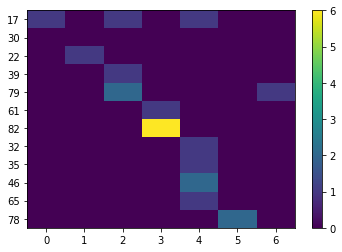

[79 35 46 78]
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
Rat  Rat08
Session 6


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


28


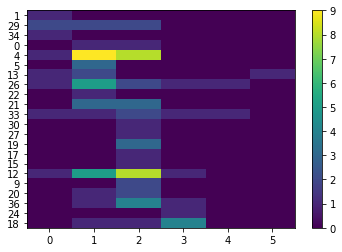

[18]
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
Rat  Rat08
Session 8


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


21


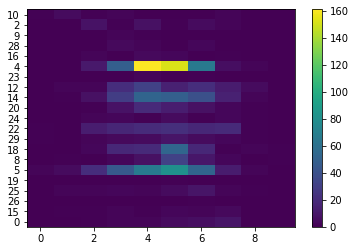

[ 8 25]
4


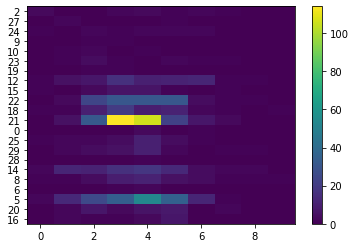

[ 2 16]
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

Rat  Rat09
Session 3


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


40


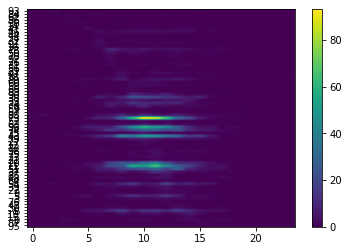

[73 40 11]
38


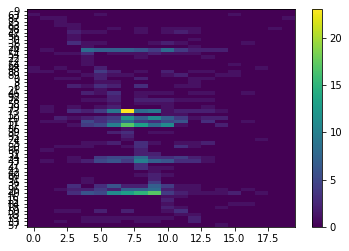

[11 73 38]
8


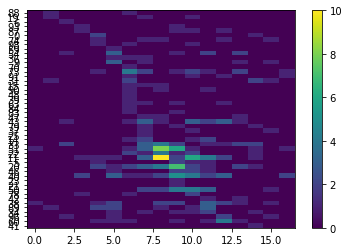

[54 31 38]
91


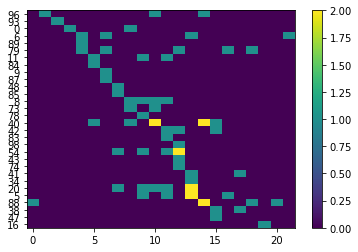

[42]
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

Rat  Rat09
Session 6


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0


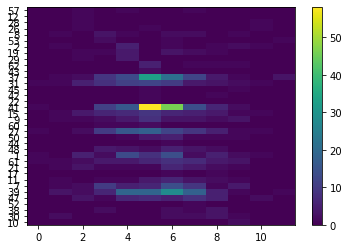

[21]
61


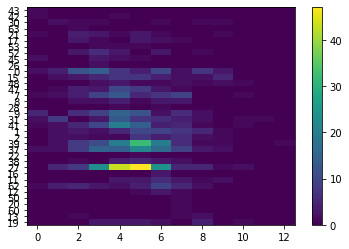

[ 0 61 27]
41


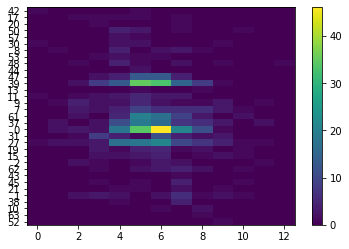

[1]
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

Rat  Rat09
Session 7


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2


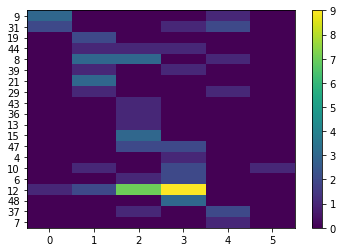

[29 10 37]
39


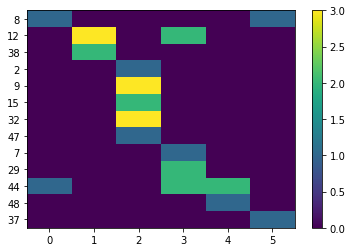

[ 7  8 12 32 47 44 29 48 37]
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

Rat  Rat09
Session 8


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


32


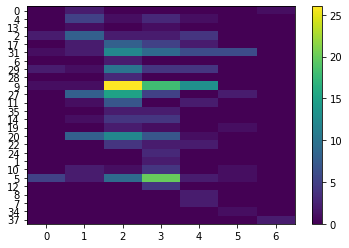

[4 0]
13


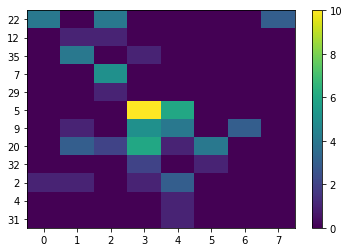

[ 9  2  4 31]
35


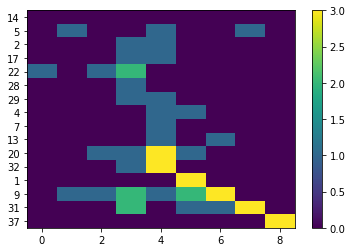

[7]
14


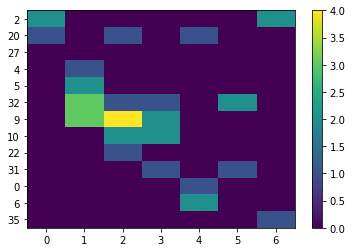

[10 31  0 35]
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:515: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat10\Rat10-20140704\Rat10-20140704-pos.csv
  self.__warning_msg(self.paths[rat][session]['position'])


Rat  Rat10
Session 3


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


26


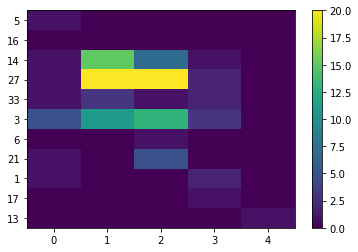

[ 6  1 17 13]
16


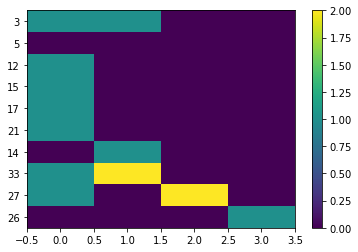

[14 26]
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:515: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat10\Rat10-20140704\Rat10-20140704-pos.csv
  self.__warning_msg(self.paths[rat][session]['position'])


Rat  Rat10
Session 6
26


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


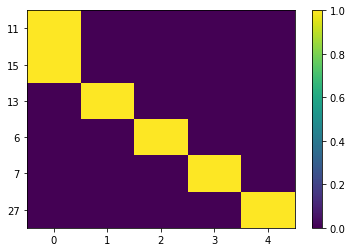

[13  6  7]
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
Rat  Rat11
Session 0


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


27


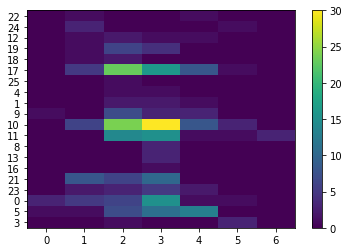

[23  3]
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
Rat  Rat11
Session 1


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


48


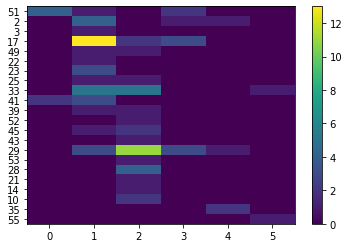

[53 29 28 35]
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
Rat  Rat11
Session 2


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


27


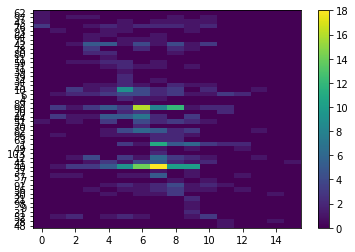

[90 27 40]
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
Rat  Rat11
Session 3


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


37


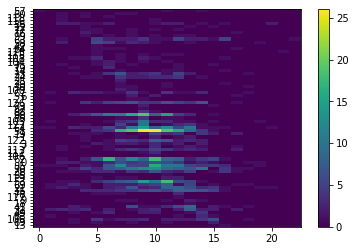

[98 37 62]
0


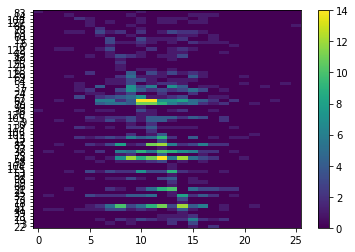

[37 62  0]
69


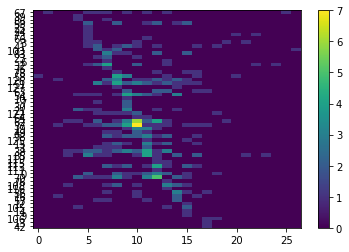

[69 37 38]
58


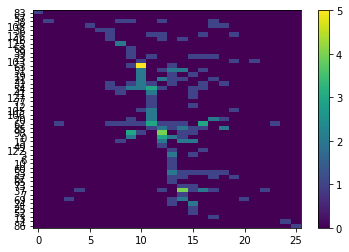

[108  16  69]
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
Rat  Rat11
Session 4


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17


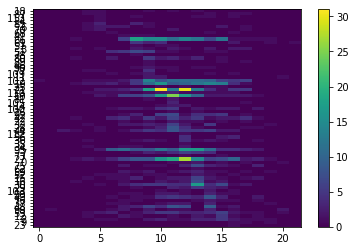

[21 10 17]
27


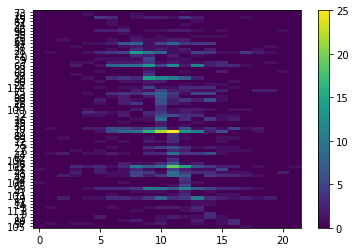

[30 27 17]
102


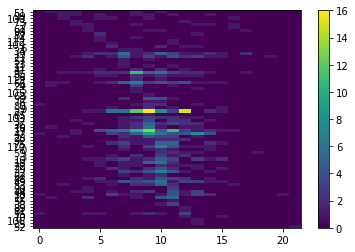

[ 27  17 102]
95


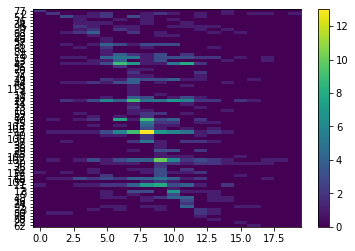

[42 17 95]
110


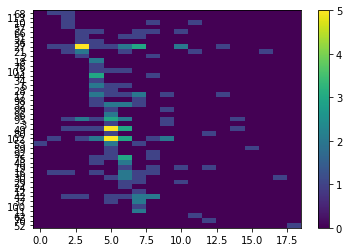

[ 21  49 110]
16


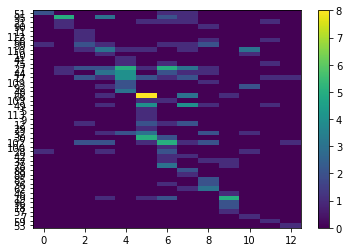

[68 51 99 17 48 66 12]
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
Rat  Rat11
Session 5


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14


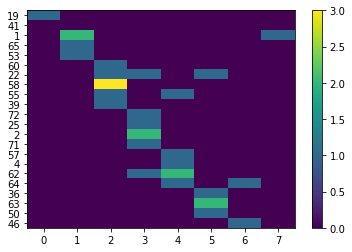

[39 55 63]


In [54]:
for session in significant_sessions:

    rat = rats[session[0]]
    
    # Load the (spike) data
    data = load_data(rat)
    spk = data.get_spk()
    
    session_nr = session[1]
    significant_neurons = session[2]

    print("Rat ", rat)
    print("Session", session_nr)

    # Define neurons, session and times of the run
    neuron_list, n_neurons, session, begin_run_t, end_run_t = session_vars(session_nr)

    # Define variables related to the location of the rats and airpuff events
    x, y, time_loc, x_mean, puff_locs_x, puff_locs_y, x_cut, y_cut = position_vars(visualization = False)

    # Construct the spike matrix 
    spk_matrix_, trial_type = spike_matrix_init(window, bin_width, visualization = False)   

    spk_matrix = mask_spikes()
    triggered_spk_matrix, trial_labels = spk_triggered(spk_matrix[:,:,1000:3000], int(seq_length*1000))

    MIs = np.zeros(len(significant_neurons))
    for ineuron, neuron in enumerate(significant_neurons):
        triggered_spk_matrix_ = triggered_spk_matrix[np.where(np.array(trial_labels)==neuron)[0]]
        firing_ranks = firing_ranks_spkmatrix(triggered_spk_matrix_, neuron)
        occ_matrix = aligned_firing_ranks2occ_matrix(firing_ranks)
        MIs[ineuron] = MI(occ_matrix)

    significant_neurons = np.array(significant_neurons)[np.argsort(MIs)]

    sequences = []
    for neuron in significant_neurons:  
        if any([neuron in seq for seq in sequences]):
            continue
        print(neuron)
        triggered_spk_matrix_ = triggered_spk_matrix[np.where(np.array(trial_labels)==neuron)[0]]
        firing_ranks = firing_ranks_spkmatrix(triggered_spk_matrix_, neuron)
        occ_matrix = aligned_firing_ranks2occ_matrix(firing_ranks)
        plt.figure()
        plt.imshow(sort_occ_matrix(occ_matrix)[0], aspect='auto')
        plt.yticks(range(sort_occ_matrix(occ_matrix)[0].shape[0]), sort_occ_matrix(occ_matrix)[2][sort_occ_matrix(occ_matrix)[1]])
        plt.colorbar()
        plt.show()

        sequence, template, null_template, MIs, MIs_surrogate, ratios  = construct_sequence(firing_ranks, n_neurons, 100, threshold=0.05, mode="max", max_neurons=15)
        print(sequence)
        sequences.append(sequence)

In [38]:
significant_sequences = []
significant_sequences.append([0, 5, [50, 79, 35, 46, 78]])
significant_sequences.append([0, 6, [28, 18]])
significant_sequences.append([0, 8, [21, 8, 25]])
significant_sequences.append([0, 8, [4, 8, 25]])

significant_sequences.append([1, 3, [40, 73, 11]])
significant_sequences.append([1, 3, [38, 11, 73]])
significant_sequences.append([1, 3, [8, 54, 31, 38]])
significant_sequences.append([1, 3, [91, 42]])
significant_sequences.append([1, 6, [0, 21]])
significant_sequences.append([1, 6, [61, 0, 27]])
significant_sequences.append([1, 6, [41, 1]])
significant_sequences.append([1, 7, [2, 29, 10, 37]])
significant_sequences.append([1, 7, [39, 7, 8, 12, 32, 47, 44, 29, 48, 37]])
significant_sequences.append([1, 8, [32, 4, 0]])
significant_sequences.append([1, 8, [13, 9, 2, 4, 31]])
significant_sequences.append([1, 8, [35, 7]])
significant_sequences.append([1, 8, [14, 10, 31, 0, 35]])

significant_sequences.append([2, 3, [26, 6, 1, 17, 13]])
significant_sequences.append([2, 3, [16, 14, 26]])
significant_sequences.append([2, 6, [26, 13, 6, 7]])

significant_sequences.append([3, 0, [27, 23, 3]])
significant_sequences.append([3, 1, [48, 53, 29, 28, 35]])
significant_sequences.append([3, 2, [27, 90, 27, 40]])
significant_sequences.append([3, 3, [37, 98, 62]])
significant_sequences.append([3, 3, [0, 37, 62]])
significant_sequences.append([3, 3, [69, 37, 38]])
significant_sequences.append([3, 3, [58, 108, 16, 69]])
significant_sequences.append([3, 4, [17, 21, 10]])
significant_sequences.append([3, 4, [27, 30, 17]])
significant_sequences.append([3, 4, [102, 27, 17, 102]])
significant_sequences.append([3, 4, [95, 42, 17]])
significant_sequences.append([3, 4, [110, 21, 49]])
significant_sequences.append([3, 4, [16, 68, 51, 99, 17, 48, 66, 12]])
significant_sequences.append([3, 5, [14, 39, 55, 63]])

Average number of neurons in a sequence:

In [39]:
np.mean([len(significant_sequences[i][2]) for i in range(len(significant_sequences))])

3.7058823529411766

Total number of sequences:

In [40]:
len(significant_sequences)

34

# Find chronological dependency per trial

In [25]:
from scipy.stats import spearmanr as spearmanr

trial_corr_list = []
trial_corr_safe_list = []

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
[50, 79, 35, 46, 78]
Rat  Rat08
Session 5
50


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


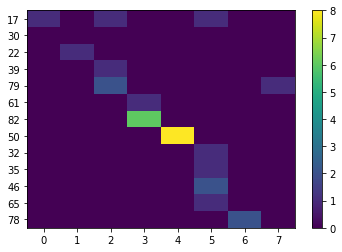

0.26666666666666666
0.08606629658238706
0.08606629658238706
0.1721325931647741
0.14907119849998599
nan
nan
nan
nan
0.1865009616480628


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_m

[0.18443459 0.18443459 0.27870222 0.24136321 0.         0.
 0.         0.        ]
[0.        0.        0.1234253 0.        0.        0.        0.
 0.       ]


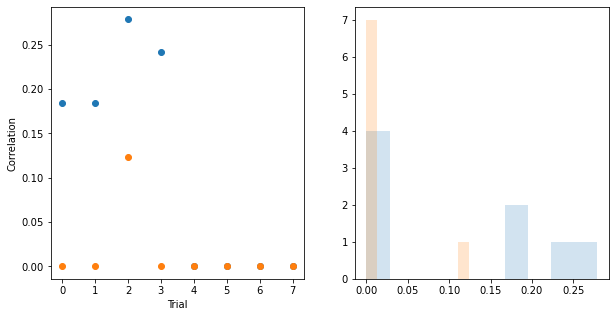

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
[28, 18]
Rat  Rat08
Session 6
28


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


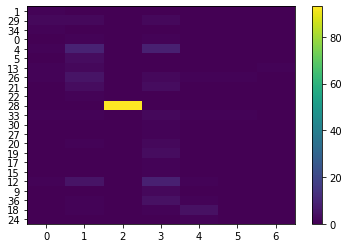

0.8795932074125605
0.7998367846560591
0.8339343387653305
0.8434937311463777
0.8566733206955398
0.6556100681071857
0.8508319756478694
0.9271726499455306
0.8994895926845297
0.8449531831132928
0.6556100681071857
0.8429272304235244
0.9271726499455306
0.7008766440504623
0.7181848464596079
0.7008766440504623
0.8195125851339821
0.8292884288627292
0.7766431633476233
0.9271726499455306
[-0.07427997 -0.06754469 -0.07042416 -0.07123144 -0.03614463 -0.05536502
 -0.07185114 -0.07829796 -0.07596018 -0.07135469 -0.05536502 -0.0711836
 -0.07829796 -0.0591877  -0.06064934 -0.0591877  -0.06920628 -0.07003183
  0.10282223 -0.07829796]
[-0.06327431 -0.06580926 -0.04520535 -0.07382003 -0.06780802 -0.03650791
 -0.07135469 -0.05872347 -0.07075756 -0.09183678 -0.06393002 -0.06920628
 -0.06852559 -0.06576746 -0.07214381 -0.06780802 -0.03290406 -0.06936905
 -0.06814963 -0.06350803]


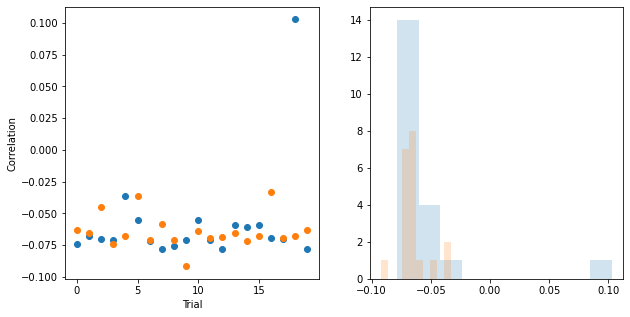

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
[21, 8, 25]
Rat  Rat08
Session 8
21


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


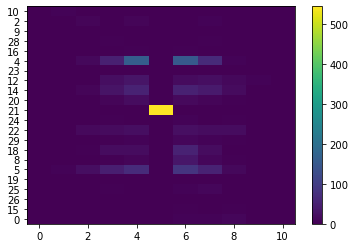

0.15101565533911399
0.12821458561166174
0.12859439390671426
0.14391841562585098
0.16817289586918557
0.13287350086318347
0.1330500362221985
0.18159378451301744
0.2103261351266931
0.14350946197048198
0.12696470256866257
0.12598815766974242
0.12724664963982193
0.1297013103501351
0.1403586535110865
0.13826464552523393
0.1685898072345246
0.21262162778128119
0.16858980723452466
0.15152288168283162
0.1263625660959576
0.1563905194695184
0.13155965941879458
0.19798709685349808
0.1337842557789571
0.15714880966764883
[0.50460477 0.48722406 0.48866735 0.51058743 0.5171772  0.50492825
 0.48571441 0.54646997 0.59045715 0.51001971 0.48247442 0.47876348
 0.48354583 0.47025881 0.50382273 0.51045136 0.59435728 0.53746979
 0.51719839 0.46237492 0.48018626 0.55963684 0.49993556 0.51631755
 0.50838918 0.46536771]
[0.50899616 0.48369192 0.59943398 0.45908401 0.52539817 0.44100454
 0.49879781 0.54817655 0.48434975 0.52933197 0.52817794 0.48753234
 0.57079796 0.59746176 0.49843902 0.49613011 0.48027256 0.5362

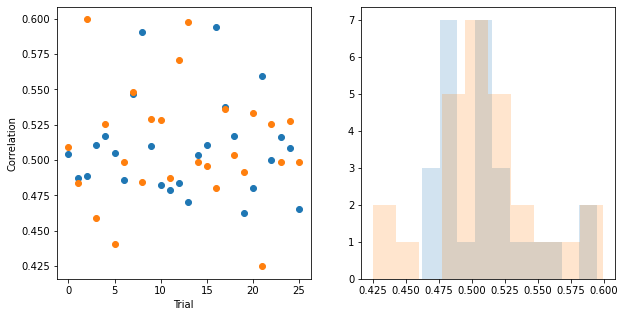

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
[4, 8, 25]
Rat  Rat08
Session 8
4


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


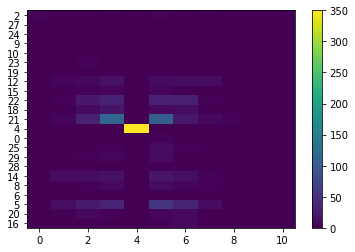

0.13094570021973104
0.122467240771248
0.12028130608117206
0.16891684887503888
0.14796861594673266
0.14554933436208792
0.14876789971477894
0.15
0.2321992552397304
0.14887433049795168
0.14096360194641513
0.11174639994246767
0.12632278815997786
0.14737658618664087
0.18628620339432236
0.1559225270396062
0.15939417826583457
0.2605958685749762
0.1401568883273698
0.17521916101261562
0.136617471887616
0.18220272220337377
0.12121212121212123
0.14306584587982538
0.11228692280886922
0.15375520133814752


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


[0.52820218 0.49400219 0.48518468 0.56738078 0.54133227 0.58710958
 0.49979867 0.4544802  0.54282688 0.5326417  0.56861188 0.450757
 0.50955451 0.48997265 0.58197858 0.54868114 0.54832001 0.53418166
 0.5269163  0.57325035 0.55108068 0.59049862 0.48893935 0.54016065
 0.45293734 0.525945  ]
[0.52497155 0.52497155 0.         0.52729823 0.55234392 0.52965728
 0.53516413 0.52487155 0.60468982 0.59015813 0.55700513 0.55525547
 0.56725708 0.49936567 0.58039571 0.49652026 0.55313579 0.59497885
 0.52615141 0.60536616 0.52616611 0.54174802 0.49087686 0.55697439
 0.49606031 0.57690441]


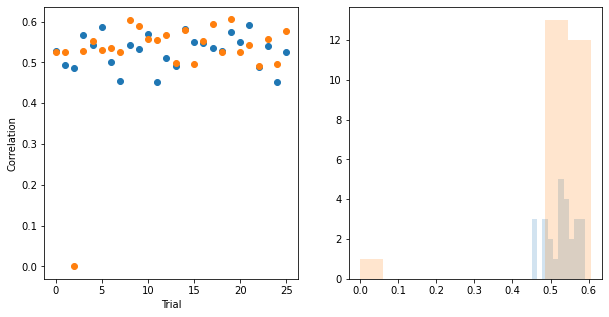

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

[40, 73, 11]
Rat  Rat09
Session 3
40


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


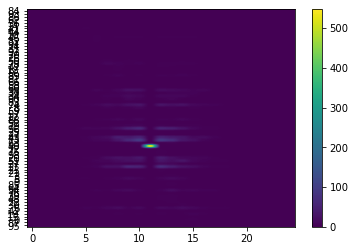

0.09933783547903956
0.14061078644744565
0.16001843940111
0.17163887030718694
0.16012815380508713
0.18376916754950667
0.2025478734167333
0.20087624854591435
0.22009898082156243
0.237056882241093
0.19582666467023893
0.23969476611277263
0.22713159647014747
0.21594395037795702
0.22152775393455215
0.2326022161242154
0.2340374680992126
0.2236466102309764
0.19490178206822872
0.19297012566268754
0.22018385688753844
0.11020775375559677
0.20920463247580556
0.23823144500331547
0.24041088549183381
0.24137370478545728
0.25438005616438797
0.22470848894089812
0.22174214849590598
0.22884793182545407
0.2192994724539355
0.20576329125782783
0.19122974798159992
0.18670672301315988
0.1779641180783397
0.15902760362413895
0.1898886313281875
0.147180996735913
0.14364705014039467
0.135548317580205
0.11804804116247142
0.17850651403771223


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


[0.55627529 0.46726935 0.57028017 0.59716532 0.57165658 0.63997394
 0.63773372 0.60467711 0.63782497 0.59757883 0.57573851 0.57221473
 0.59337627 0.61295432 0.58489922 0.61818455 0.62722998 0.56443962
 0.5639937  0.57195611 0.55052699 0.37428086 0.58377484 0.57715961
 0.57107756 0.62259243 0.63367446 0.50881972 0.57678383 0.55537128
 0.60570476 0.55412912 0.55212613 0.61018558 0.52696907 0.55627528
 0.50931013 0.49376327 0.5595199  0.49439876 0.59867049 0.5624995 ]
[0.49206812 0.42092498 0.53155992 0.29292275 0.57228915 0.39622474
 0.57636035 0.48024397 0.48081377 0.57503795 0.47840342 0.48190387
 0.54123728 0.45405184 0.51276884 0.55702476 0.50323851 0.56657843
 0.54960577 0.49397514 0.57388844 0.51899529 0.52910661 0.49332196
 0.49031941 0.58865171 0.36827361 0.45368184 0.45101225 0.31563458
 0.37938247 0.26407884 0.32955487 0.44467594 0.         0.26407884
 0.25811846 0.         0.32199304 0.         0.         0.        ]


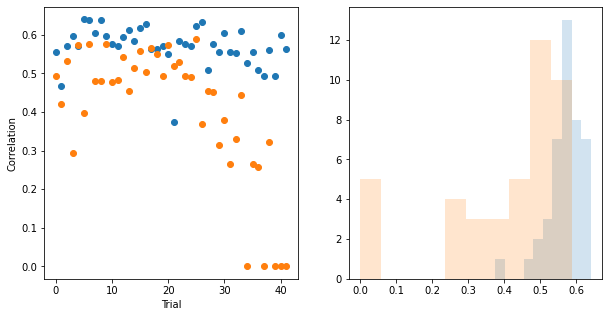

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

[38, 11, 73]
Rat  Rat09
Session 3
38


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


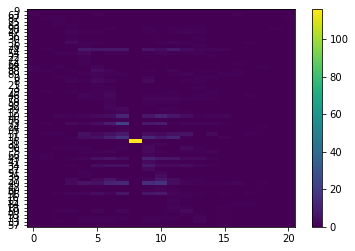

0.06978631577988531
nan
0.14272480642961255
0.09304842103984709
nan
nan
nan
nan
0.16514456476895412
nan
nan


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))


nan
nan
nan
nan
nan
nan
0.15378928962175847
0.22457930782767732
0.09304842103984709
0.2022599587389726
0.13511046418374104
0.2136183479338211
nan
0.19284730395996752
0.1895117478716537
0.22156468376279892
0.08703882797784891
0.1688801323682996
nan
0.09304842103984709
0.17301295082447832
0.10772843571098122
0.1659765325773231
0.128564869306645
0.13121597027036946
0.22036911889497712
0.16412198797244365
0.11945967147042724
0.11579473428470961
0.13434332265596974
0.17782168978975482


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


[0.34104844 0.         0.51472515 0.25420477 0.         0.
 0.         0.         0.42568993 0.         0.         0.
 0.         0.         0.         0.         0.         0.36235438
 0.51235357 0.27865922 0.44431701 0.43455179 0.5134978  0.
 0.38356252 0.49667498 0.46832123 0.26066183 0.3832088  0.
 0.27865922 0.47141581 0.44378988 0.56913419 0.37785859 0.40662256
 0.52673625 0.40170691 0.48302774 0.48306624 0.45997508 0.46433908]
[0.31850174 0.16591639 0.21948675 0.24796459 0.30950617 0.1599584
 0.         0.35456815 0.3689537  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.41942711 0.41841106 0.23030736 0.
 0.383555   0.25489123 0.21094792 0.         0.50797098 0.45619372
 0.38801987 0.33267941 0.47889135 0.44360172 0.34172844 0.52009086
 0.56006734 0.42806912 0.4899752  0.3689537  0.27483165 0.47047974]


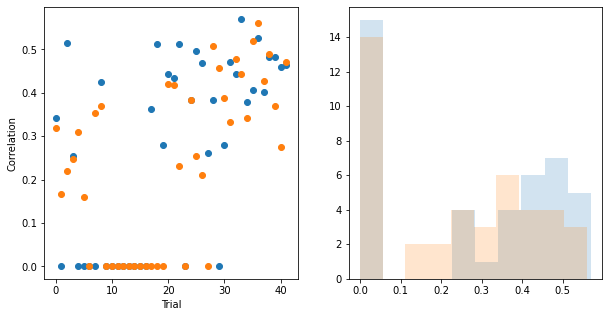

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

[8, 54, 31, 38]
Rat  Rat09
Session 3
8


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


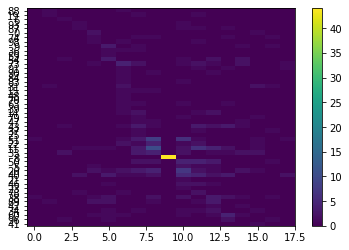

0.14107202341170869
nan
nan
nan
nan
nan
nan
nan
nan
nan
0.08111071056538126
nan


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))


0.05735393346764044
nan
nan
nan
nan
nan
nan
nan
nan
0.14580660420062558
nan
nan
0.07647191129018725
0.04055535528269063
nan
0.09210526315789473
nan
0.051298917604257706
0.043355498476206
0.07254762501100118
nan
0.09365858115816941
0.08998425413316952
0.048911598804451846
0.046829290579084706
nan
nan
nan
nan
0.09567297464698798


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


[0.30497947 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.25619202 0.
 0.3329336  0.         0.         0.         0.         0.
 0.         0.         0.         0.505637   0.         0.
 0.218412   0.2354196  0.         0.41527731 0.         0.29778486
 0.25167414 0.22365978 0.         0.26749898 0.38967695 0.28392673
 0.27183914 0.         0.         0.         0.         0.30218762]
[0.         0.40258562 0.         0.17429188 0.         0.39018543
 0.2354196  0.         0.         0.         0.         0.
 0.29778486 0.30319298 0.20076651 0.         0.         0.
 0.2354196  0.         0.         0.24016777 0.         0.
 0.         0.         0.46445681 0.         0.         0.
 0.         0.         0.         0.         0.38434407 0.38593644
 0.41945045 0.         0.38818116 0.29778486 0.34588715 0.2105657 ]


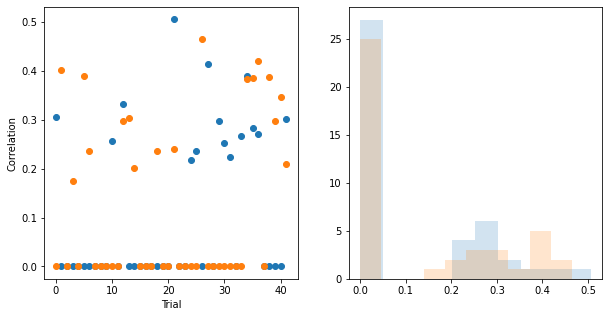

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

[91, 42]
Rat  Rat09
Session 3
91


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


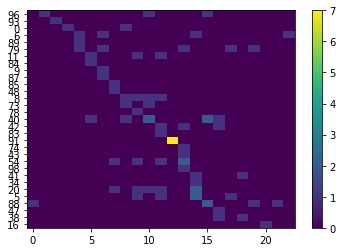

0.5148226420013364
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))


nan
nan
nan
nan
nan
nan
nan
0.3457962481114516
nan
nan
nan
nan
nan
nan
nan
0.3992911138638185
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


[ 0.01829135  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03961003  0.          0.          0.          0.
  0.          0.          0.         -0.04573772  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
[ 0.          0.          0.         -0.06868344  0.          0.
  0.          0.         -0.04777149  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]


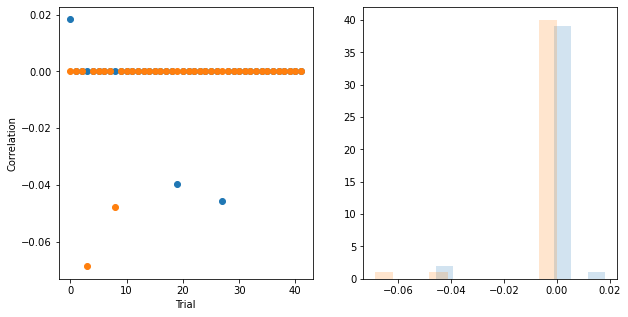

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

[0, 21]
Rat  Rat09
Session 6
0


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


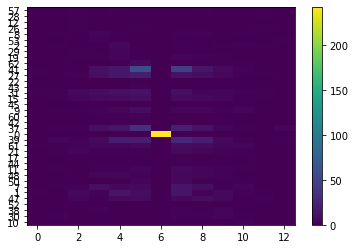

0.19733244073364778
0.11338934190276817
0.14409760442605876
0.10910894511799621
0.12104550653376049
0.12446097204675335
0.08451542547285167
0.09449111825230681
0.12979353291279128
0.1520172480262651
0.1350447409819031
0.1469861839480328
0.1018266349953196
0.1375047745542317
0.15291587997987086
0.13231403100624078
0.1375047745542317
0.13552618543578768
0.14744195615489714
0.1360323904477358
0.15130688316720062
0.12777531299998798
0.18712029714127998
0.17200824030811301
0.147481543202504
0.14409760442605876
0.15152288168283162
0.11458731212852642
0.16448792373994228
0.15275252316519466
0.1548308843213331
0.20003306604965973
0.18593393604027367
0.1649572197684645
0.1690308509457033
0.1468446196428705
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

[61, 0, 27]
Rat  Rat09
Session 6
61


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


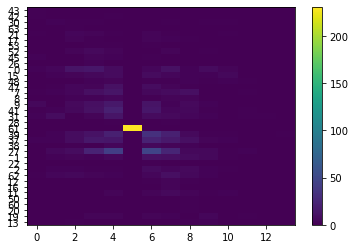

0.6016870890901647
0.8132710071494413
0.6100195847719233
0.7618145450774895
0.7704046134398
0.7820752194835302
0.7024859470472942
0.8246918737846526
0.6049961172818221
0.6089047886406999
0.7457539250262759
0.7337749725177556
0.7575274422932361
0.705540651287698
0.6310547428675068
0.7456096443679158
0.7008870275363439
0.6578703935175145
0.6415723219152987
nan
0.7317091157615132
0.658504607868518
0.62415776263595
0.46188477719918836
0.6892748177781076
0.6310547428675068


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))


0.6313833316650234
0.6373618987068246
0.6519887053102966
0.6206047437637795
nan
nan
0.6979592188787735
nan
0.669854717465401
nan


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

[41, 1]
Rat  Rat09
Session 6
41


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


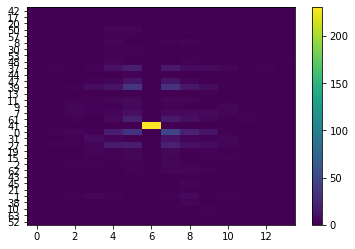

0.8032807347608434
0.7312802945041761
0.8546940982389203
0.728564127036043
0.8000090704490441
0.7348904176365958
0.7910701410569345
0.6425331647667465
0.8131207285564991
0.7643429177921489
0.6425331647667465
0.6682748860824972
0.6235838191959893
0.6425331647667465
0.7869391982470798
0.7414600684968513
0.5971448892989649
0.6924141787209063
0.636342771674271
0.7549920035756421
0.8219311860630469
0.43102435026495545
0.7435876483894032
0.7107168799264036
0.7950942264016846
0.7118132872932729
0.7619506023221891
0.535471621862359
0.6654807777941303
0.7164287418718589
0.6459777814016092
0.5346199088659978
0.36509428763342655
0.4618118038553094
0.43102435026495545
0.5272960024972738


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

[2, 29, 10, 37]
Rat  Rat09
Session 7
2


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


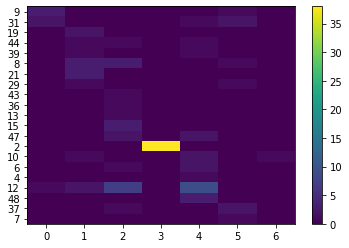

C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))


nan
nan
0.26516504294495535
0.11316968255314819
nan
0.11785113019775792
0.1767766952966369
nan
0.10206207261596577
nan
0.08838834764831845
nan
0.20412414523193154
nan
nan
nan
0.15875015875023812
nan
nan
0.2165063509461097
0.125
nan
0.19611613513818404
nan
nan
0.125
0.15811388300841897
0.14433756729740646
0.125
nan
nan
nan
0.15975241260567344
0.125


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

[39, 7, 8, 12, 32, 47, 44, 29, 48, 37]
Rat  Rat09
Session 7
39


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


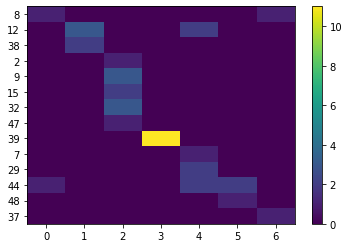

0.207880460155075
nan
nan
nan
nan
nan
nan
nan
nan
0.21957751641342
nan
nan
nan
nan
nan
nan
nan
nan
0.1290994448735806
nan
nan
nan
0.28987545218210153
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_m

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

[32, 4, 0]
Rat  Rat09
Session 8
32


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


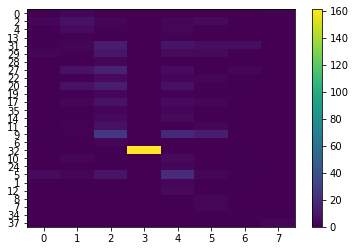

C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))


nan
nan
nan
nan
nan
nan
nan
nan
nan
0.3606678538669729
0.3606678538669729
nan
nan
nan
0.6246950475544243
0.5410017808004594
0.5100613704506707
nan
0.6246950475544242
nan
0.6246950475544243
0.7032542426631453
0.5936657514041415
0.6451822708364093
0.6224158018602045
0.6080335103257678
0.7466533929465573
0.693036930918736
0.7600418879072098
0.6269504345122826
0.6381308867560207
0.39509183865983577
0.5896370411997258
0.7140859186309387
0.6443237444802804
0.7140271533822173
0.6649813555672313
0.7534105749568176
0.5809545937052777
0.6886966936819877
nan
0.6246950475544242
0.5100613704506706
0.7238018199114888
0.7872732303132517
0.4900511134653511
0.7281089615690532
0.3756527420083569
nan
0.7165743639000186
nan


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.06569843 -0.06569843  0.
  0.          0.         -0.11379302 -0.09854765 -0.09291161  0.
 -0.11379302  0.         -0.11379302 -0.12810318  0.01562047 -0.11752493
 -0.11494411 -0.11075799 -0.13600867 -0.12624202 -0.09700786 -0.07770325
 -0.11624046 -0.07196903 -0.10740693 -0.13007626 -0.11736854 -0.13006555
 -0.03817133 -0.13723955 -0.10582536 -0.12886502  0.         -0.11379302
 -0.09291161 -0.13184608 -0.14340789 -0.08926659 -0.13263066 -0.01153458
  0.         -0.13052955]
[ 0.          0.         -0.11379302  0.          0.          0.
  0.         -0.08759791 -0.11075799  0.          0.         -0.08046382
  0.         -0.11989478 -0.10795354 -0.09704301 -0.12465401  0.
  0.         -0.14131282  0.         -0.11379302 -0.09291161  0.
 -0.09291161  0.          0.          0.          0.          0.
  0.          0.          0.         -0.07196903  0.          0.
  0.          0.

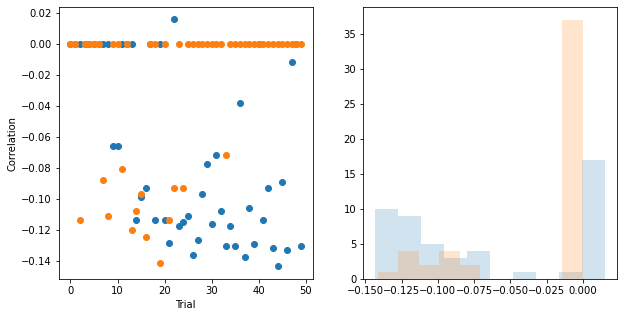

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

[13, 9, 2, 4, 31]
Rat  Rat09
Session 8
13


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


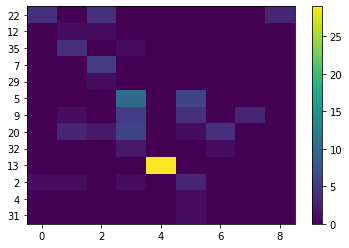

C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))


nan
nan
0.1341640786499874
nan
nan
nan
nan
nan
nan
nan
nan
0.1414213562373095
nan
nan
nan
nan
nan
0.08164965809277261
0.15689290811054724
nan
nan
nan
nan
nan
0.23094010767585033
nan
nan
nan
0.16329931618554522
0.17320508075688773
0.08164965809277261
nan
nan
nan
nan
0.15374122295716147
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
0.11547005383792516
nan
nan
nan
nan


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


[0.         0.         0.22732537 0.         0.         0.
 0.         0.         0.         0.         0.         0.22169053
 0.         0.         0.         0.         0.         0.22116764
 0.18253412 0.         0.         0.         0.         0.
 0.24946668 0.         0.         0.         0.44233529 0.19739444
 0.22116764 0.         0.         0.         0.         0.29498514
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.31277828 0.
 0.         0.        ]
[0.         0.         0.         0.         0.         0.
 0.13951799 0.         0.27710087 0.         0.         0.27087394
 0.         0.         0.         0.273624   0.18227529 0.
 0.         0.         0.         0.23269254 0.         0.
 0.         0.28498899 0.         0.         0.31351776 0.
 0.24183228 0.18956761 0.32047431 0.1915368  0.         0.
 0.         0.1915368  0.         0.         0.         0.
 0.23763498 0.         0.         0.         0.1080

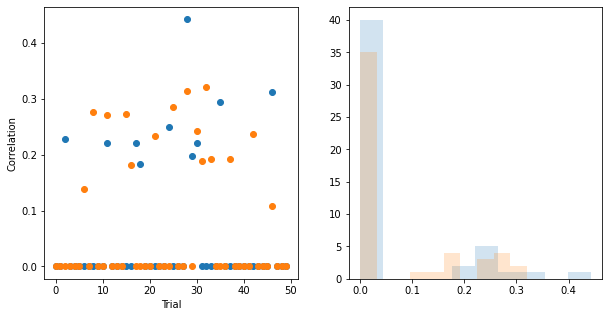

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

[35, 7]
Rat  Rat09
Session 8
35


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


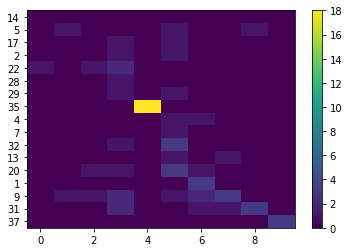

0.547996624351191
0.6003002251876642
0.794358864749432
nan
nan
nan
nan
nan
0.660908796128813
0.4821727440152546
nan
nan
nan
nan
nan
nan
nan
0.4745789978762495
nan
nan
nan
0.547996624351191
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))


0.6711560552140243
nan
nan
nan
nan


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


[-0.13974833 -0.15308663 -0.07267103  0.          0.          0.
  0.          0.         -0.16854283 -0.12296214  0.          0.
  0.          0.          0.          0.          0.         -0.12102561
  0.          0.          0.         -0.13974833  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.17115606  0.
  0.          0.        ]
[-0.20021755 -0.15308663  0.         -0.16136748 -0.18041432 -0.15308663
  0.         -0.17115606  0.          0.          0.          0.
 -0.13974833  0.         -0.24205121  0.          0.          0.
  0.         -0.18297352  0.         -0.17115606 -0.1514135  -0.13974833
  0.          0.05229193  0.          0.          0.          0.
  0.          0.          0.         -0.13974833  0.         -0.17115606
  0.          0.          0.    

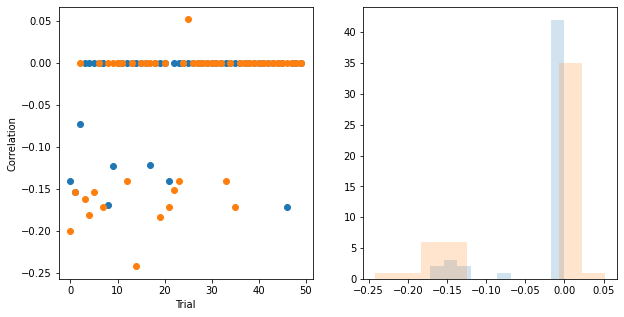

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140324\Rat09-20140324.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140325\Rat09-20140325.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:590: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat09\Rat09-20140326\Rat09-20140326.rip.evt
  self.__warning_msg(path)
C:\Users\pepij\OneDrive\Documenten\02 AI\4 

[14, 10, 31, 0, 35]
Rat  Rat09
Session 8
14


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


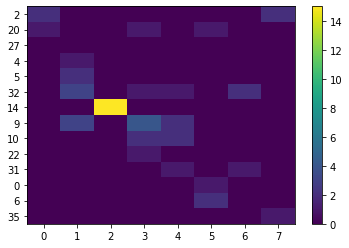

C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_m

nan
nan
nan
nan
nan
nan
nan
nan
0.18257418583505539
nan
nan
nan
nan
nan
0.1777046633277277
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
0.10540925533894598
nan
nan
nan
nan
0.1126872339638022
0.1414213562373095
nan
nan
nan
0.08606629658238706
0.15936381457791918
nan
nan
nan
[0.         0.         0.         0.         0.         0.
 0.         0.         0.32773618 0.         0.         0.
 0.         0.         0.28588166 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.24814414 0.         0.         0.         0.         0.26527724
 0.33292029 0.         0.         0.         0.20260884 0.30834336
 0.         0.        ]
[0.         0.         0.         0.         0.24814414 0.
 0.26088011 0.02154996 0.         0.         0.         0.20260884
 0.         0.16403867 0.         0.         0.  

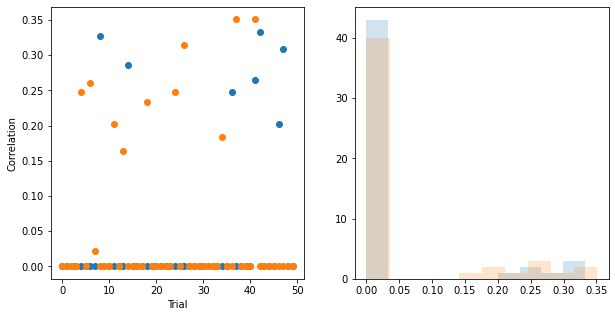

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:515: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat10\Rat10-20140704\Rat10-20140704-pos.csv
  self.__warning_msg(self.paths[rat][session]['position'])


[26, 6, 1, 17, 13]
Rat  Rat10
Session 3
26


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


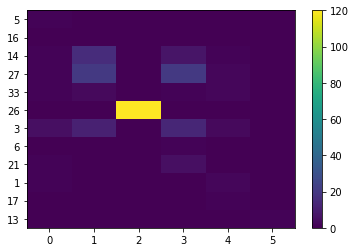

0.669774686623137
0.7195524177001851
0.5358258812338202
0.5653337710833066
0.6963575181639444
0.6387468457023774
0.6943650748294135
0.6378879538497859
0.6013377943029548
0.6629126073623881
0.6338656910463873
0.3572172541558801
0.7499999999999999
0.735147044114705
0.7211429607306172
0.7499999999999999
0.7086833868923009
0.5669467095138407
0.7499999999999999
0.6997653965219282
0.6735198826004059
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:515: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat10\Rat10-20140704\Rat10-20140704-pos.csv
  self.__warning_msg(self.paths[rat][session]['position'])


[16, 14, 26]
Rat  Rat10
Session 3
16


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


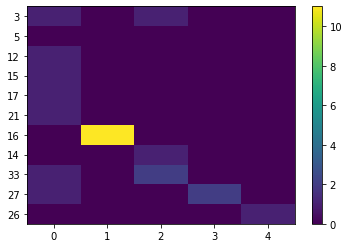

C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_m

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
0.2631174057921088
0.17817416127494956
nan
nan
nan
nan
nan
0.23570226039551584
0.16666666666666666
nan
C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\data_loader.py:515: UserWarning: The file does not exist in the dataset, check the folder 
 C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\Rat10\Rat10-20140704\Rat10-20140704-pos.csv
  self.__warning_msg(self.paths[rat][session]['position'])


[26, 13, 6, 7]
Rat  Rat10
Session 6
26


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


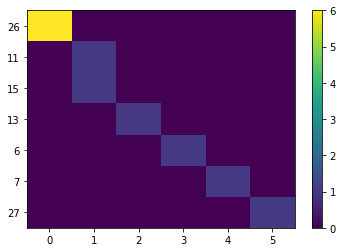

C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_m

nan
nan
nan
nan
nan
0.7947194142390264
0.7108186533109109
nan
nan
nan
0.5619514869490164
nan
nan
0.6622661785325219
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
[ 0.          0.          0.          0.          0.         -0.29471941
 -0.26360506  0.          0.          0.         -0.2083981   0.
  0.          0.17106715  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
[ 0.          0.         -0.17015633  0.         -0.22846631  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.14735971]


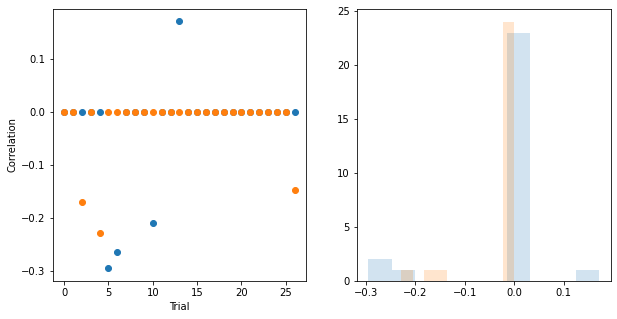

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
[27, 23, 3]
Rat  Rat11
Session 0
27


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


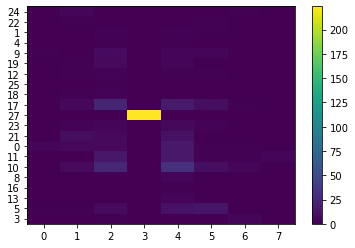

0.7769150179140312
0.7872732303132517
0.6246950475544243
0.7477823439274305
0.7918059610880441
0.7391491482878365
0.7328778119358672
0.7261932421315971
0.8179178119091962
0.5889681390658481
0.8107113471010238
0.7165743639000186
0.820264783195062
0.7436186600034299
0.7391491482878365
0.7165743639000186
0.7328778119358672
0.7824987744390042
0.8575894485643644
0.8200902402027263
0.7422483197348518
0.8401271123972639
0.816751855775585
0.8329267300725656
0.8278323291940067
0.7598766434465316
0.8415583256896034
0.7853897988345
0.816751855775585
0.8381163549234938


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


[-0.06910986 -0.14359454 -0.11394113 -0.11168896 -0.12102185 -0.13481696
 -0.1336731  -0.13245387 -0.14918396 -0.10742473 -0.14786954 -0.13069944
 -0.14961203 -0.1084089  -0.13481696 -0.13069944 -0.1336731  -0.11330876
 -0.15641986 -0.1495802  -0.13538223 -0.12857715 -0.14897129 -0.15192151
 -0.15099231 -0.09466872 -0.15349586 -0.14325102 -0.14897129]
[-0.10742473 -0.12481625 -0.12481625 -0.13024556 -0.11394113 -0.11090215
 -0.13407416 -0.12146165 -0.12180819 -0.14011067 -0.13245387 -0.05568273
 -0.12180819 -0.1417     -0.13386418 -0.14102556 -0.14918396 -0.11394113
  0.         -0.13817391 -0.10191204 -0.14065198 -0.08056855 -0.13428091
 -0.14412539 -0.14412539 -0.15226024  0.         -0.11394113]


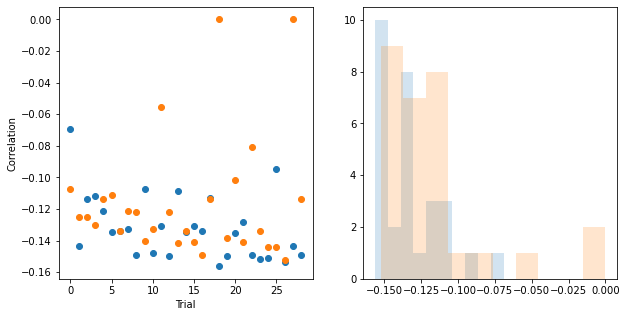

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
[48, 53, 29, 28, 35]
Rat  Rat11
Session 1
48


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


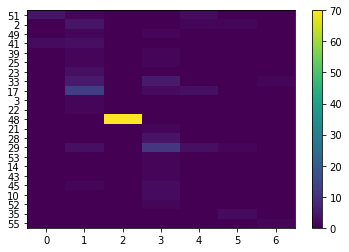

C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))


nan
nan
0.2236067977499789
0.12909944487358055
0.18898223650461357
0.1739313106957345
nan
0.18257418583505536
0.15363382425529626
0.15811388300841894
0.18633899812498247
0.21213203435596423
0.14804664203952103
0.179284291400159
0.15430334996209188
nan
0.14142135623730948
nan
0.15811388300841894
0.18257418583505536
0.09128709291752768
0.19084657134227861
0.15811388300841894
0.15811388300841894
0.18257418583505536
nan
nan


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
[27, 90, 27, 40]
Rat  Rat11
Session 2
27


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


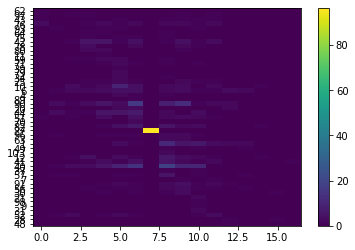

0.1805787796286538
0.1466471150213533
0.22650696184537056
0.0816496580927726


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))


nan
0.13608276348795434
0.21297171444596252
0.09901475429766743
0.14814814814814814
0.1781741612749496
0.21606040536255622
0.07856742013183862
0.055555555555555566
0.23570226039551584
nan
0.21384434262392826
0.15452877499092177
0.06085806194501846
0.14054567378526128
0.24959226008892244
0.21252557102111275
0.21516574145596762
0.26194175932858044
0.1650245904961124
0.10286889997472794
0.24652466565114894
nan
0.20215947828770758
0.16666666666666669
0.2018433569398328


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


[0.44665229 0.3874449  0.46005439 0.43934232 0.         0.38134077
 0.4040006  0.3741107  0.39248978 0.22990017 0.41743235 0.20643227
 0.29893458 0.41854617 0.         0.42037272 0.5012563  0.32746643
 0.36620605 0.48233492 0.48276805 0.49816906 0.45336407 0.35673222
 0.28826653 0.53551466 0.         0.5551066  0.6435965  0.62347451]
[0.29193932 0.40100394 0.24862142 0.33340962 0.24862142 0.
 0.28708329 0.27675964 0.25794711 0.28371695 0.29893458 0.29320593
 0.32746643 0.3661186  0.23179964 0.         0.30624977 0.25888494
 0.34422264 0.         0.40513036 0.33149523 0.31136344 0.29893458
 0.3661186  0.39953384 0.         0.42275734 0.22470945 0.42275734]


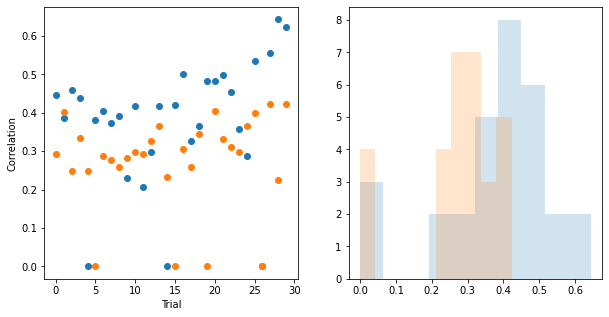

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
[37, 98, 62]
Rat  Rat11
Session 3
37


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


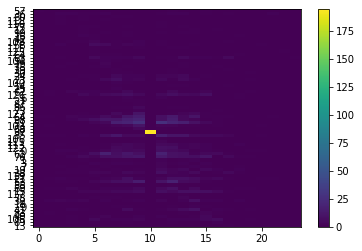

0.1127203723953269
0.09093977234462833
0.14267527500128432
0.17432038578211326
0.06531972647421808
0.10596258856520349
0.12080808993852438
0.1408721450120998
0.09730672655996822
0.16772557387550693
0.16329931618554522
0.10954451150103321
0.1675415633166782
0.10141851056742199
0.15727141989855695
0.09874838622020374
0.1400437705184995
0.1282485421534174
0.15650160901149995
0.09948743896214962
0.16984155512168936
0.1188177051572009
0.09428090415820635
0.1528186354916682
0.15186527932039984
0.11547005383792515
0.10773446351236618
0.19245008972987526
0.14863210712350766
0.20034692133618848
0.11925695879998877
[0.49152977 0.44329899 0.43354964 0.49168863 0.31980751 0.26778822
 0.43345352 0.34481153 0.38271688 0.44356786 0.44869316 0.3478365
 0.4706395  0.53289321 0.47163638 0.46939629 0.52804093 0.46852569
 0.49088246 0.35356215 0.46518627 0.39697791 0.31538596 0.54649307
 0.40762466 0.38867459 0.52674011 0.51469172 0.47326294 0.54950586]
[0.3473368  0.44170322 0.25492115 0.4716532  0.34383

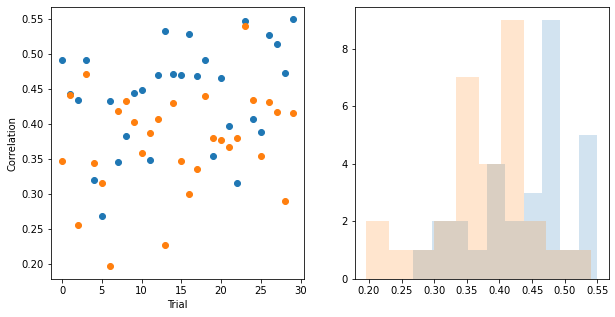

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
[0, 37, 62]
Rat  Rat11
Session 3
0


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


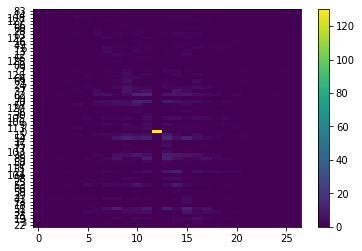

0.06900655593423542
0.11065666703449761
0.11437725271791939
0.04652421051992354
0.12104550653376048
0.08763841367493648
0.11396057645963795
0.10778636357219332
0.101162829777814
0.1358957080545352
0.07715167498104596
0.08319479070496523
0.09652341781316803
0.11647270698695132
0.10762440050012628
0.09304842103984708
0.09100315103865803
0.11009045464637501
0.1234572911646078
0.13488539609929065
0.078742598543589
0.07938841860374447
nan
0.10550699226799948


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))


0.12488459050258424
0.12269377914491109
0.0885422004151433
0.1301797937910665
0.09741723051615438
0.12299229029889691
0.1129051677598016


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


[0.2707721  0.3944493  0.29551784 0.33527366 0.4195135  0.32048528
 0.39190056 0.4215177  0.41695332 0.4572243  0.26611708 0.47450724
 0.31921097 0.36733909 0.37852254 0.33014922 0.3197431  0.35729215
 0.48332926 0.31106121 0.32454596 0.39157242 0.         0.38416485
 0.41578082 0.5618449  0.4133771  0.35214021 0.49753811 0.42706682]
[0.28164376 0.3901657  0.3944185  0.30288258 0.33775206 0.44039572
 0.32086613 0.28300859 0.2017127  0.3097334  0.35423184 0.40075731
 0.23707428 0.25848888 0.30344319 0.42329598 0.30318999 0.45796186
 0.25467478 0.32877045 0.30254937 0.35662546 0.28000062 0.35064392
 0.38646681 0.         0.17644405 0.25625676 0.43846299 0.31303321]


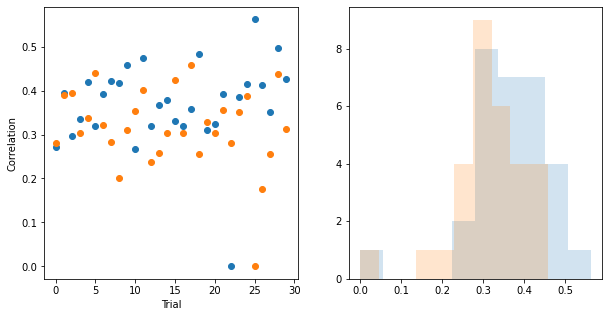

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
[69, 37, 38]
Rat  Rat11
Session 3
69


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


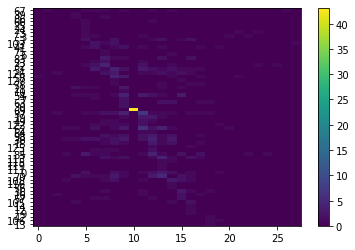

0.41504037331397264
nan


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))


0.6102731468335304
0.3216479078379362
nan
0.42728136365123265
nan
0.35334337965071994
0.3331353331178625
nan
0.3852406757085166
nan
0.3160399265194103
nan
0.35334337965071994
0.34115912518000546
0.4188007680882736
0.28850366137826033
nan
0.37773996186793873
nan
nan
0.3647144459414581
0.5082799130689131
nan
0.515923648949515
0.40800579071543075
0.3117230137698452
0.4585589215526908
0.4997029996767937
0.28850366137826033


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


[-0.00213099  0.          0.05643331 -0.02397325  0.         -0.03107102
  0.          0.01501022 -0.02305756  0.         -0.02700711  0.
  0.04872542  0.         -0.02445624 -0.02542747 -0.00628184  0.01616176
  0.         -0.00952396  0.          0.         -0.02718311 -0.02213723
  0.         -0.02129245  0.06290424 -0.00676922 -0.02087409  0.03518115]
[-0.01729317 -0.00983159 -0.03496785  0.00436649  0.00282266 -0.02871447
 -0.00781705 -0.02727056  0.01280076 -0.01797994 -0.02058045 -0.01827243
 -0.00727404 -0.01937538 -0.03364095 -0.02718311 -0.02187433 -0.02168462
  0.          0.02773238 -0.02414293 -0.03321831  0.         -0.01918505
 -0.03236883 -0.03087424 -0.02640037 -0.02874317  0.         -0.00952396]


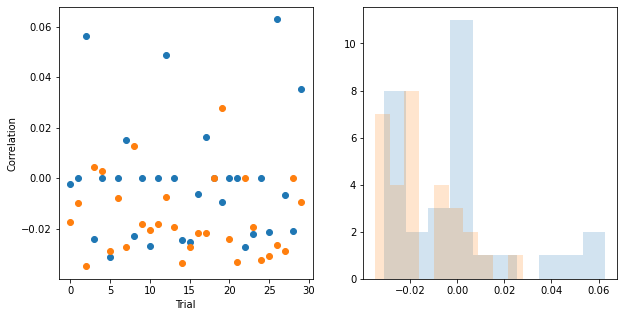

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
[58, 108, 16, 69]
Rat  Rat11
Session 3
58


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


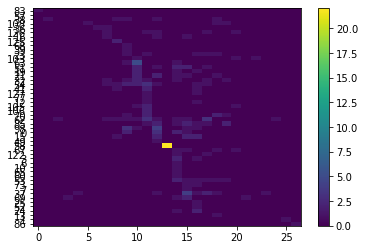

C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))


nan
0.0314970394174356
0.12604604334137906
nan
nan
nan
0.02727723627949905
0.042257712736425826
0.02988071523335984
nan
0.03857583749052298
0.025253813613805267
nan
nan
nan
0.06875238727711584
nan
nan
0.035714285714285705
nan
nan
nan
nan
0.06681531047810609
0.03340765523905304
nan
0.04791574237499549
nan
0.06503324771430899
0.0314970394174356
0.035714285714285705


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


[0.         0.2074122  0.33171157 0.         0.         0.
 0.17962424 0.27827267 0.19676849 0.         0.25402703 0.16629973
 0.         0.         0.         0.34844443 0.         0.
 0.23518333 0.         0.         0.         0.         0.27105338
 0.21999386 0.         0.31553155 0.         0.32959543 0.2074122 ]
[0.16629973 0.23518333 0.         0.         0.         0.
 0.         0.         0.         0.         0.21999386 0.
 0.29332515 0.27827267 0.         0.21999386 0.3111183  0.2074122
 0.         0.         0.         0.         0.         0.
 0.         0.         0.25402703 0.         0.27827267 0.        ]


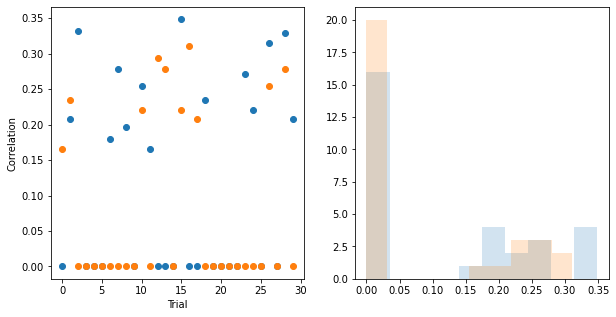

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
[17, 21, 10]
Rat  Rat11
Session 4
17


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


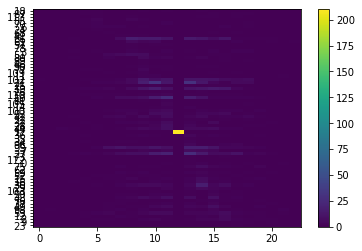

0.1718304372588172
0.15731330124142312
0.1449377260910507
0.08574929257125442
0.12598815766974242
0.13944333775567924
0.20614035087719296
0.13845786012261624
0.1634301126151534
0.14404027024170413
0.10942202738310212
0.2213496259194483
0.08838834764831843
0.14708710135363803
0.12286829679574762
0.17849054062078637
0.1860521018838127
0.1588677079397994
0.1524431867933412
0.15238922883268416
0.13900960937138318
0.17213259316477406
0.07106690545187015
0.08838834764831845
0.11270870433342903
0.08606629658238703
0.08748177652797065
0.18064673536794584
0.0797516914862107


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


[0.4864116  0.50831094 0.4005999  0.4556627  0.43678676 0.50741155
 0.57925152 0.49412098 0.51567179 0.42277033 0.41742383 0.56547816
 0.3594329  0.40089484 0.31466992 0.47101122 0.48870203 0.38869426
 0.42227204 0.45934475 0.48150294 0.40094093 0.45898694 0.4718044
 0.55046284 0.40809045 0.38192987 0.5084794 ]
[0.48752216 0.49929819 0.46591549 0.4720996  0.49692176 0.49583694
 0.4781371  0.48950231 0.5033746  0.51823381 0.47647427 0.52357429
 0.         0.50358971 0.3712207  0.52058486 0.38882693 0.43192908
 0.47612832 0.47460809 0.45001214 0.38057187 0.35032631 0.34928523
 0.4427243  0.         0.33553135 0.4049476 ]


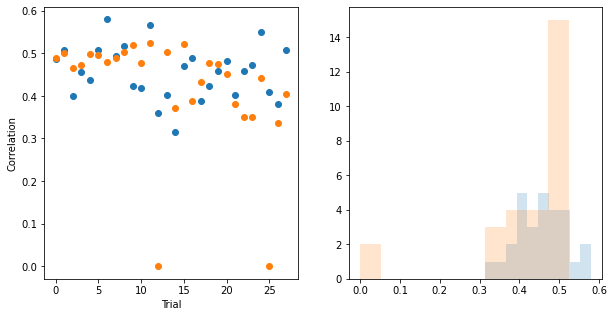

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
[27, 30, 17]
Rat  Rat11
Session 4
27


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


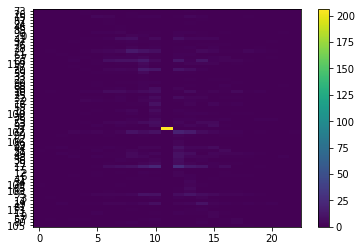

0.11123730207865243
0.11551721334727866
0.11135885079684349
0.1705466252048397
0.09128709291752769
0.09428090415820634
0.15909902576697318
0.21316287119398175
0.10540925533894598
0.1386750490563073
0.14377703093791788
0.14814814814814814
0.15172774624376745
0.21442250696755896
0.07804881763180783
0.16060401860990525
0.13176156917368248
0.12651201921276495
0.11350087076783313
0.17857142857142858
0.0920262717290388
0.09993755853278154
0.1359820733051053
0.11644928267462809
0.14336088815212542
0.14573094163086459
0.08333333333333334
0.13900275738816908
0.14922354519125183


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


[0.50500138 0.5377425  0.50496096 0.49255004 0.48361244 0.46353835
 0.43977322 0.56711133 0.31970791 0.52242096 0.48546122 0.48035883
 0.52951505 0.44334066 0.39265653 0.40564321 0.50182651 0.5949389
 0.43844092 0.48072425 0.53720451 0.49456078 0.57611736 0.5274487
 0.52265418 0.54253085 0.35788546 0.37014315]
[0.38967555 0.54837193 0.54665639 0.49709343 0.40065035 0.46515092
 0.43017211 0.51659355 0.56103703 0.46528846 0.52120705 0.38337268
 0.41723119 0.49265227 0.42557456 0.         0.47851396 0.37450036
 0.48042421 0.50868267 0.48530613 0.42540985 0.52109321 0.35370493
 0.49476317 0.47163367 0.53173216 0.48333196]


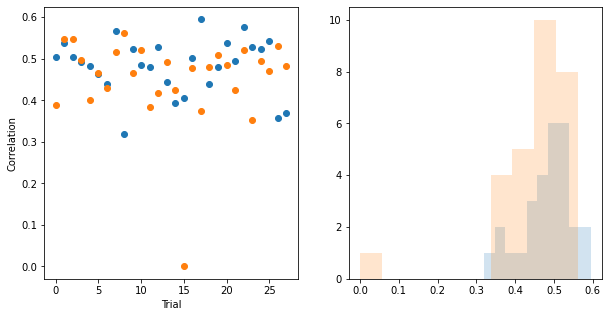

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
[102, 27, 17, 102]
Rat  Rat11
Session 4
102


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


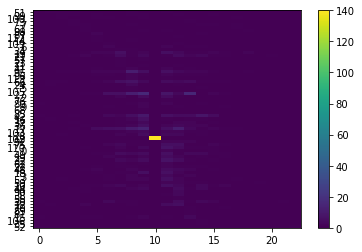

0.6660887153949013
0.6685004078131501
0.6383350189201138
0.7149214304008848
0.544588948703754
0.5156868498964312
0.43490743579065516
0.7123812193854512
0.5585877747095475
0.5890265878980199
0.6823628056598201
0.48663422546630625
0.7379086779222014
0.5848615507714904
0.6903644831420975
0.6280630496861761
0.703652481437109
0.6592581180267079
0.4689324732180449
0.7332359661135014
0.6707143314740326
0.6166783209442782
0.6250009419026887
0.713291028925526
0.7032229667946374
0.6536570013758884
0.6991344611737382
0.6684935492532128
0.5357031157680442


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


[-0.03562564  0.02453176 -0.04962642 -0.01401088  0.02765623  0.0411242
  0.01301689  0.04979339  0.00380824 -0.02342919 -0.00477312  0.0120864
  0.01485755 -0.00105134 -0.04390762 -0.03004397 -0.02397571  0.04129888
 -0.00248793 -0.02972368  0.03848671 -0.00367783  0.04253177  0.01615008
  0.01359485  0.02322994 -0.01939918 -0.01995899]
[-0.00388322  0.05276752  0.03989196  0.          0.         -0.03416601
  0.0074846   0.01628225 -0.04061172  0.02853565 -0.02157646 -0.03721982
 -0.01000696 -0.03401494 -0.04074474 -0.04448366  0.00235478 -0.04845607
 -0.01162174  0.00933375  0.00673085 -0.01837908  0.00744984 -0.01568868
  0.011668   -0.02008259 -0.01495041 -0.01730309]


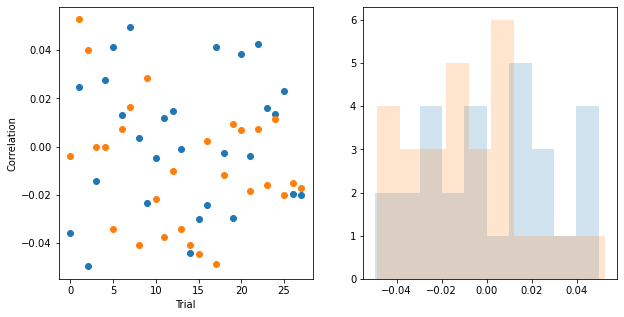

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
[95, 42, 17]
Rat  Rat11
Session 4
95


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


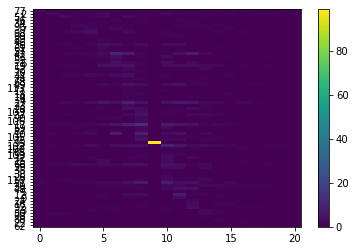

0.4165986796468039
0.5859172032567102
0.661583077599287
0.468775433384897
0.5505386303477302
0.389289598824034
0.5718820653441088
0.5187216642366632
0.5471576037111876
0.6067748395916331
0.45835820153189927
0.5638503315807165
0.40782719876803564
0.4919163266187081
0.5142448028237353
0.5964065096154186
0.6366153167338795
0.537810087969396
0.5541280452774838
0.4935283840579615
0.5643523571317925
0.4881323548754873
0.389289598824034
0.5067970282771997
0.5146201570780331
0.5461068532255493
0.37757461785338287
0.3757644619833714
0.588709770601673
[ 0.02253193  0.02501781  0.03057546  0.00945435 -0.04093449 -0.02894505
  0.02376088 -0.02181069 -0.00585559  0.01027774  0.03954732  0.00573167
  0.02643418 -0.02219653  0.01368239  0.00558851 -0.00919416  0.01999483
  0.01576426 -0.01295539  0.02408782 -0.02744563 -0.02894505 -0.0249013
 -0.02415408  0.02884185  0.03212706 -0.03006808]
[-0.03661292 -0.04987743 -0.03170772 -0.03111076 -0.02612974 -0.02124342
 -0.0251458  -0.03015962 -0.03416455 -

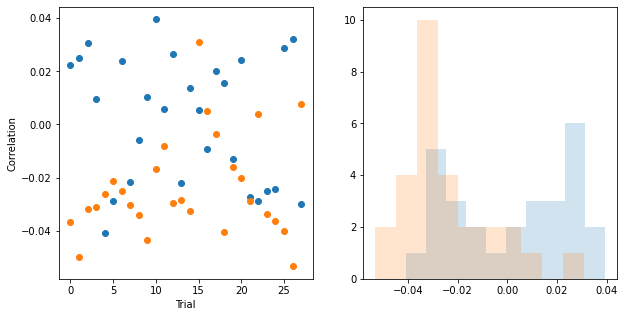

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
[110, 21, 49]
Rat  Rat11
Session 4
110


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


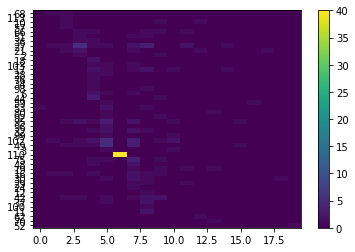

0.5382019315025577
0.6706824069493411
0.6765560069081112
0.5492350363810898
0.5879987183670695
0.6049991748538784
0.3309112606779028
nan
0.30117007526118195
0.4756514941544941
nan
0.2579066441642642
0.4994340688622188
0.7368761261836121
0.9513029883089882
0.38836781869030873


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))


0.9513029883089882
0.38836781869030873
0.6726727939963125
nan
nan
0.6726727939963124
0.5629659122906171
0.353153216848064
0.38836781869030873
0.4756514941544941
nan
0.4756514941544941
0.4157778810863538


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


[ 0.02108414 -0.06379752 -0.00220693 -0.07563281 -0.07272644 -0.02059535
  0.07980956  0.         -0.0126176  -0.06549994  0.         -0.01080507
  0.08161397 -0.10147207 -0.13099988 -0.05348048 -0.13099988 -0.05348048
 -0.0926309   0.          0.         -0.0926309   0.00930344 -0.03896386
 -0.05348048 -0.06549994  0.         -0.06549994]
[-0.00371979  0.03568522  0.01417059  0.01185597  0.05440931 -0.06549994
 -0.05029499 -0.03687858 -0.09789302  0.01325538  0.05770979 -0.05646722
 -0.0789959  -0.0495133   0.         -0.08936369  0.          0.
 -0.0622792   0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


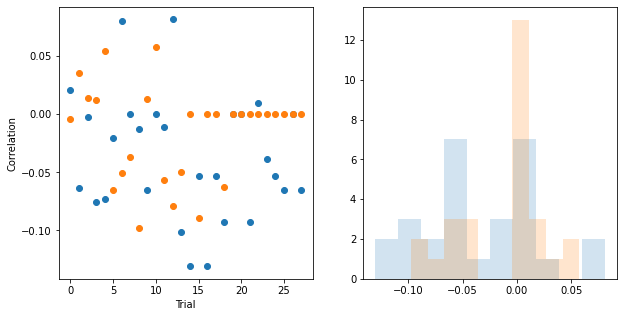

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
[16, 68, 51, 99, 17, 48, 66, 12]
Rat  Rat11
Session 4
16


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


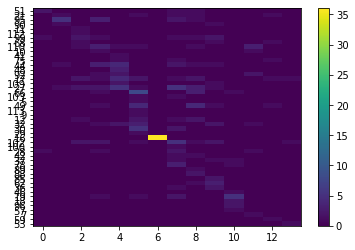

0.052704627669472995
nan
0.04564354645876384
0.037267799624996496
nan
nan
0.11952286093343936
nan
0.06454972243679027
nan
nan
nan
0.07784989441615228
0.0408248290463863
nan
nan
nan
0.1118033988749895
nan
nan
nan


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))


0.04879500364742666
nan
0.09507653770830568
nan
nan
nan
0.17679827843514556
0.19623283621077794


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


[0.24634306 0.         0.21333935 0.17419085 0.         0.
 0.18727123 0.         0.3017074  0.         0.         0.
 0.26133004 0.19081651 0.         0.         0.         0.18650433
 0.         0.         0.         0.22806935 0.         0.21921128
 0.         0.         0.         0.3642484 ]
[0.2904481  0.17419085 0.         0.24634306 0.         0.1508537
 0.         0.         0.         0.1836549  0.         0.23277154
 0.         0.15202724 0.19077546 0.         0.16268882 0.28387667
 0.23127334 0.12945945 0.11083605 0.12023036 0.19907692 0.22680294
 0.06327166 0.         0.06327166 0.31250001]


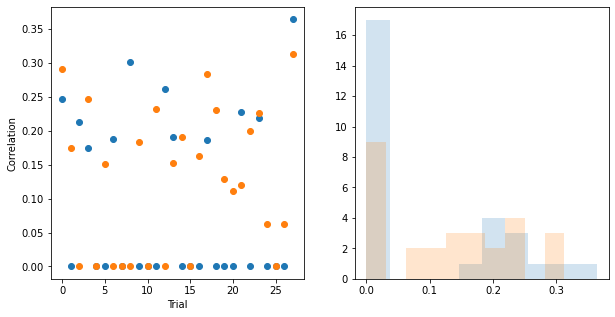

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\
[14, 39, 55, 63]
Rat  Rat11
Session 5
14


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


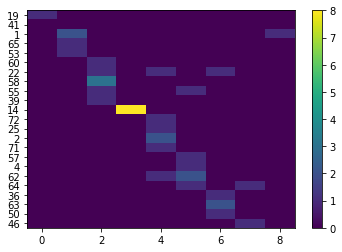

C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:78: RuntimeWarning: invalid value encountered in divide
  trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:79: RuntimeWarning: invalid value encountered in divide
  print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))


nan
nan
0.15811388300841894
nan
nan
nan
nan
0.1348399724926484
nan
nan
nan
0.09128709291752768
0.06454972243679027
0.07071067811865474
0.07905694150420947
nan
nan
0.16770509831248417
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


C:\Users\pepij\AppData\Local\Temp\ipykernel_18116\3822820020.py:91: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


In [26]:
spearman_statistics = []
spearman_pvals = []

for sig_sequence in significant_sequences:
    seq_length=0.05
    window = (-1000, 1000)


    rat = rats[sig_sequence[0]]
    
    # Load the (spike) data
    data = load_data(rat)
    spk = data.get_spk()
    
    session_nr = sig_sequence[1]
    sequence_neurons = sig_sequence[2]
    print(sequence_neurons)
    print("Rat ", rat)
    print("Session", session_nr)
    print(sequence_neurons[0])

    # Define neurons, session and times of the run
    neuron_list, n_neurons, session, begin_run_t, end_run_t = session_vars(session_nr)

    # Define variables related to the location of the rats and airpuff events
    x, y, time_loc, x_mean, puff_locs_x, puff_locs_y, x_cut, y_cut = position_vars(visualization = False)

    # Construct the spike matrix 
    spk_matrix_, trial_type = spike_matrix_init(window, bin_width, visualization = False)   
    
    spk_matrix = mask_spikes()
    
    triggered_spk_matrix, trial_labels = spk_triggered(spk_matrix[:,:,1000:3000], int(seq_length*1000))
    triggered_spk_matrix_ = triggered_spk_matrix[np.where(np.array(trial_labels)==sequence_neurons[0])[0]]
    firing_ranks = firing_ranks_spkmatrix(triggered_spk_matrix_, sequence_neurons[0])
    occ_matrix = firing_ranks2occ_matrix(firing_ranks)
    
    plt.figure()
    plt.imshow(sort_occ_matrix(occ_matrix)[0], aspect='auto')
    plt.yticks(range(sort_occ_matrix(occ_matrix)[0].shape[0]), sort_occ_matrix(occ_matrix)[2][sort_occ_matrix(occ_matrix)[1]])
    plt.colorbar()
    plt.show()

    max_ranks = np.argmax(occ_matrix[sequence_neurons], axis=1)
    sequence = np.array(sequence_neurons)[np.argsort(max_ranks)]

    occurrence_matrix_filtered = np.zeros([occ_matrix.shape[0], occ_matrix.shape[1]])
    
    for seq_neur in sequence:
        occurrence_matrix_filtered[seq_neur] = occ_matrix[seq_neur]/np.sum(occ_matrix[seq_neur])

    # Create the null-template
    null_template = np.zeros([occ_matrix.shape[0], occ_matrix.shape[1]])
    active = np.array([occ_matrix[:,col].any() for col in range(occ_matrix.shape[1])])
    lim1 = np.argwhere(active)[0,0]
    lim2 = np.argwhere(active)[-1][0]
    for neuron in range(occ_matrix.shape[0]):
        if neuron == sequence_neurons[0]:
            null_template[neuron,:] = occurrence_matrix_filtered[neuron,:]
        elif neuron in sequence_neurons:
            null_template[sequence,lim1:lim2+1] = 1/(lim2-lim1)
                
    
    trial_corr = np.zeros([len(mask_spikes())])
    trial_corr_safe = np.zeros([len(mask_spikes(puff=False))])
    
    for itrial_slice, trial_slice in enumerate(spk_matrix):
        spk_matrix_slice = spk_matrix[itrial_slice,:,1000:3000].reshape([1, spk_matrix.shape[1], int(spk_matrix.shape[2]/2)])
        triggered_spk_matrix, trial_labels = spk_triggered(spk_matrix_slice, int(seq_length*1000))
        triggered_spk_matrix_ = triggered_spk_matrix[np.where(np.array(trial_labels)==sequence_neurons[0])[0]]
        ranks = firing_ranks_spkmatrix(triggered_spk_matrix_, sequence_neurons[0])
        occurrence_matrix = firing_ranks2occ_matrix(ranks)
        #plt.figure()
        #plt.imshow(sort_occ_matrix(occurrence_matrix)[0], aspect='auto')
        #plt.yticks(range(sort_occ_matrix(occurrence_matrix)[0].shape[0]), sort_occ_matrix(occurrence_matrix)[2][sort_occ_matrix(occurrence_matrix)[1]])
        #plt.colorbar()
        #plt.show()
        trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
        print(np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix)))
    spk_matrix = mask_spikes(puff=False)
    triggered_spk_matrix, trial_labels = spk_triggered(spk_matrix[:,:,1000:3000], int(seq_length*1000))
    triggered_spk_matrix_ = triggered_spk_matrix[np.where(np.array(trial_labels)==sequence_neurons[0])[0]]
    
    for itrial_slice, trial_slice in enumerate(spk_matrix):
        spk_matrix_slice = spk_matrix[itrial_slice,:,1000:3000].reshape([1, spk_matrix.shape[1], int(spk_matrix.shape[2]/2)])
        triggered_spk_matrix, trial_labels = spk_triggered(spk_matrix_slice, int(seq_length*1000))
        triggered_spk_matrix_ = triggered_spk_matrix[np.where(np.array(trial_labels)==sequence_neurons[0])[0]]
        ranks = firing_ranks_spkmatrix(triggered_spk_matrix_, sequence_neurons[0])
        occurrence_matrix = firing_ranks2occ_matrix(ranks)        
        
        trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
    
    for ival, val in enumerate(trial_corr):
        if np.isnan(val):
            trial_corr[ival] = 0

    for ival, val in enumerate(trial_corr_safe):
        if np.isnan(val):
            trial_corr_safe[ival] = 0
    
    width=0
    spk_matrix = mask_spikes()
    

    if len(trial_corr)-len(trial_corr_safe) == 2:
        trial_corr = trial_corr[1:len(trial_corr)-1]

    if len(trial_corr)-len(trial_corr_safe) == 1:
        trial_corr = trial_corr[:len(trial_corr)-1]

    if len(trial_corr) != len(trial_corr_safe):
        continue

    

    trial_corr_list.append(trial_corr)
    trial_corr_safe_list.append(trial_corr_safe)

    ind = np.arange(len(trial_corr))
    
    print(trial_corr)
    print(trial_corr_safe)
    
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.scatter(ind,trial_corr)
    spk_matrix = mask_spikes(puff=False)
    plt.scatter(ind,trial_corr_safe)
    #plt.ylim([0,1])
    plt.xlabel('Trial')
    plt.ylabel('Correlation')
    
    plt.subplot(1, 2, 2)

    plt.hist(trial_corr, bins=10, alpha=0.2)
    plt.hist(trial_corr_safe, bins=10, alpha=0.2)
    #plt.savefig('Figure14.svg')
    #plt.savefig('Figure14.jpg')
    plt.show()

    spearman_statistics.append(spearmanr(trial_corr, trial_corr_safe)[0])
    spearman_pvals.append(spearmanr(trial_corr, trial_corr_safe)[1])

In [28]:
nr_significant =  len(np.array(spearman_statistics)[np.where(np.array(spearman_pvals) <= 0.05)[0]])
nr_in_total = len(np.array(spearman_statistics))

print(nr_significant)
print(nr_in_total)

4
25


In [37]:
np.array(spearman_pvals)[np.where(np.array(spearman_pvals) <= 0.05)[0]]

array([0.02174276, 0.03218977, 0.00023262, 0.02028299])

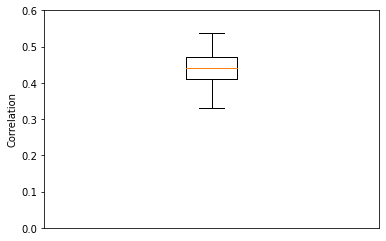

In [30]:
significant_coefficients = np.array(spearman_statistics)[np.where(np.array(spearman_pvals) <= 0.05)[0]]

plt.figure()
plt.boxplot(significant_coefficients)
plt.xticks([])
plt.ylim([0.0,0.6])
plt.ylabel('Correlation')
plt.show()

In [ ]:
plt.figure()
plt.hist(trial_corr, bins=10, alpha=0.2)
plt.hist(trial_corr_safe, bins=10, alpha=0.2)
plt.show()

In [86]:
np.mean(significant_coefficients)

0.4398543067231748

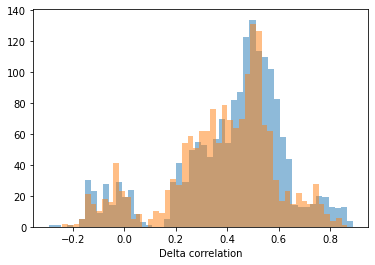

In [131]:
trial_corr_list_flattened = []
for l in trial_corr_list:
    for elem in l:
        if elem != 0:
            trial_corr_list_flattened.append(elem)
trial_corr_safe_list_flattened = []
for l in trial_corr_safe_list:
    for elem in l:
        if elem != 0:
            trial_corr_safe_list_flattened.append(elem)

plt.figure()
plt.hist(trial_corr_list_flattened, bins=50, alpha=0.5) 
plt.hist(trial_corr_safe_list_flattened, bins=50, alpha=0.5) 
plt.xlabel('Delta correlation')
plt.show()

# Case example rat11, session 4, locked at 27:

In [25]:
retrieved_neurons=[30,17,27] # These neurons were retrieved by the sequence retrieval method.

C:\Users\pepij\OneDrive\Documenten\02 AI\4 Thesis\GG-Dataset-Tulio-Ultralight\


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


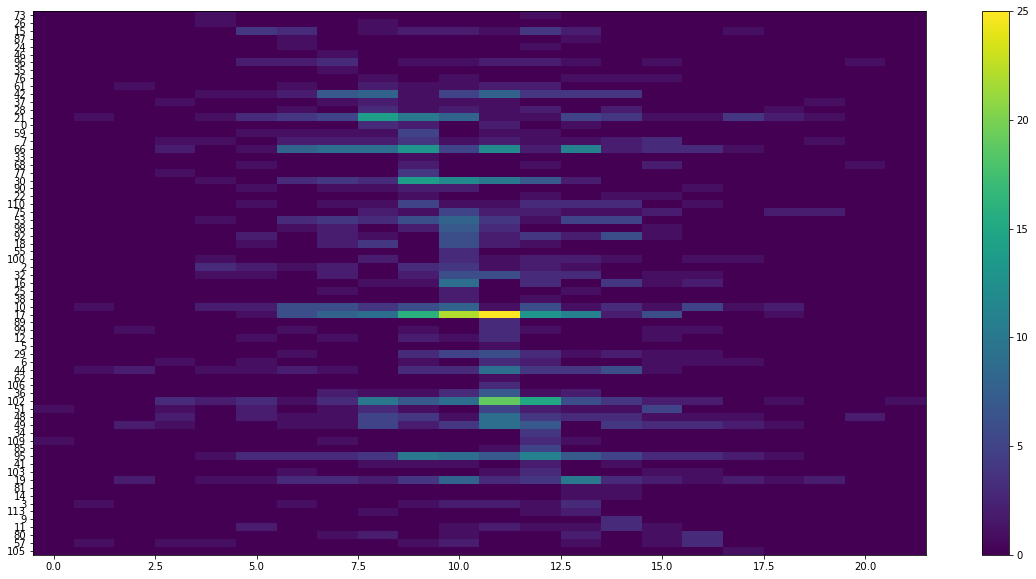

In [40]:
### seq_length=0.05
window = (-1000, 1000)

rat = rats[3]

# Load the (spike) data
data = load_data(rat)
spk = data.get_spk()

session_nr = 4
sequence_neurons = [27,30,17]

# Define neurons, session and times of the run
neuron_list, n_neurons, session, begin_run_t, end_run_t = session_vars(session_nr)

# Define variables related to the location of the rats and airpuff events
x, y, time_loc, x_mean, puff_locs_x, puff_locs_y, x_cut, y_cut = position_vars(visualization = False)

# Construct the spike matrix 
spk_matrix_, trial_type = spike_matrix_init(window, bin_width, visualization = False)   

spk_matrix = mask_spikes()

triggered_spk_matrix, trial_labels = spk_triggered(spk_matrix[:,:,1000:3000], int(seq_length*1000))
triggered_spk_matrix_ = triggered_spk_matrix[np.where(np.array(trial_labels)==sequence_neurons[0])[0]]
firing_ranks = firing_ranks_spkmatrix(triggered_spk_matrix_, sequence_neurons[0])

occ_matrix = aligned_firing_ranks2occ_matrix(firing_ranks)
plt.figure(figsize=(20,10))
plt.imshow(sort_occ_matrix(occ_matrix)[0], aspect='auto')
plt.yticks(range(sort_occ_matrix(occ_matrix)[0].shape[0]), sort_occ_matrix(occ_matrix)[2][sort_occ_matrix(occ_matrix)[1]])
plt.colorbar()
plt.show()

[30 27 17]


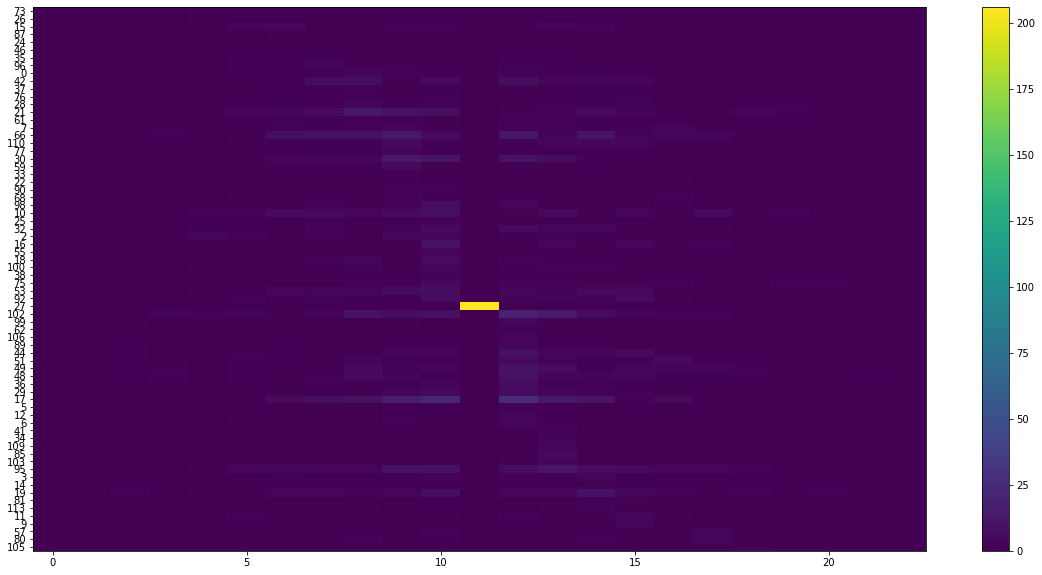

C:\Users\pepij\AppData\Local\Temp\ipykernel_24700\3293388361.py:55: RuntimeWarning: invalid value encountered in divide
  trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


[0.50500138 0.5377425  0.50496096 0.49255004 0.48361244 0.46353835
 0.43977322 0.56711133 0.31970791 0.52242096 0.48546122 0.48035883
 0.52951505 0.44334066 0.39265653 0.40564321 0.50182651 0.5949389
 0.43844092 0.48072425 0.53720451 0.49456078 0.57611736 0.5274487
 0.52265418 0.54253085 0.35788546 0.37014315]
[0.38967555 0.54837193 0.54665639 0.49709343 0.40065035 0.46515092
 0.43017211 0.51659355 0.56103703 0.46528846 0.52120705 0.38337268
 0.41723119 0.49265227 0.42557456 0.         0.47851396 0.37450036
 0.48042421 0.50868267 0.48530613 0.42540985 0.52109321 0.35370493
 0.49476317 0.47163367 0.53173216 0.48333196]


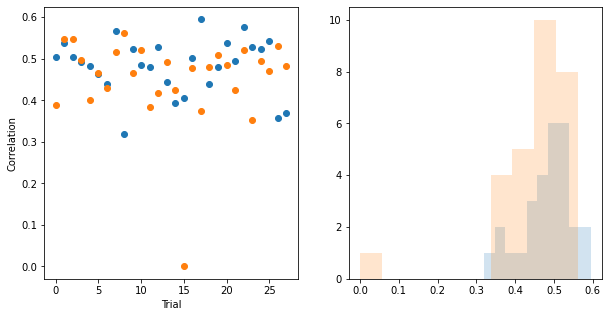

-0.03338806787082649
0.8660602737371457


In [42]:
occ_matrix = firing_ranks2occ_matrix(firing_ranks)

max_ranks = np.argmax(occ_matrix[sequence_neurons], axis=1)
sequence = np.array(sequence_neurons)[np.argsort(max_ranks)]
print(sequence)
occurrence_matrix_filtered = np.zeros([occ_matrix.shape[0], occ_matrix.shape[1]])

plt.figure(figsize=(20,10))
plt.imshow(sort_occ_matrix(occ_matrix)[0], aspect='auto')
plt.yticks(range(sort_occ_matrix(occ_matrix)[0].shape[0]), sort_occ_matrix(occ_matrix)[2][sort_occ_matrix(occ_matrix)[1]])
plt.colorbar()
plt.show()

for seq_neur in sequence:
    occurrence_matrix_filtered[seq_neur] = occ_matrix[seq_neur]/np.sum(occ_matrix[seq_neur])

# Create the null-template
null_template = np.zeros([occ_matrix.shape[0], occ_matrix.shape[1]])
active = np.array([occ_matrix[:,col].any() for col in range(occ_matrix.shape[1])])
lim1 = np.argwhere(active)[0,0]
lim2 = np.argwhere(active)[-1][0]
for neuron in range(occ_matrix.shape[0]):
    if neuron == sequence_neurons[0]:
        null_template[neuron,:] = occurrence_matrix_filtered[neuron,:]
    elif neuron in sequence_neurons:
        null_template[sequence,lim1:lim2+1] = 1/(lim2-lim1)
            

trial_corr = np.zeros([len(mask_spikes())])
trial_corr_safe = np.zeros([len(mask_spikes(puff=False))])

for itrial_slice, trial_slice in enumerate(spk_matrix):
    spk_matrix_slice = spk_matrix[itrial_slice,:,1000:3000].reshape([1, spk_matrix.shape[1], int(spk_matrix.shape[2]/2)])
    triggered_spk_matrix, trial_labels = spk_triggered(spk_matrix_slice, int(seq_length*1000))
    triggered_spk_matrix_ = triggered_spk_matrix[np.where(np.array(trial_labels)==sequence_neurons[0])[0]]
    ranks = firing_ranks_spkmatrix(triggered_spk_matrix_, sequence_neurons[0])
    occurrence_matrix = firing_ranks2occ_matrix(ranks)
    #plt.figure()
    #plt.imshow(sort_occ_matrix(occurrence_matrix)[0], aspect='auto')
    #plt.yticks(range(sort_occ_matrix(occurrence_matrix)[0].shape[0]), sort_occ_matrix(occurrence_matrix)[2][sort_occ_matrix(occurrence_matrix)[1]])
    #plt.colorbar()
    #plt.show()
    trial_corr[itrial_slice] = np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
spk_matrix = mask_spikes(puff=False)
triggered_spk_matrix, trial_labels = spk_triggered(spk_matrix[:,:,1000:3000], int(seq_length*1000))
triggered_spk_matrix_ = triggered_spk_matrix[np.where(np.array(trial_labels)==sequence_neurons[0])[0]]

for itrial_slice, trial_slice in enumerate(spk_matrix):
    spk_matrix_slice = spk_matrix[itrial_slice,:,1000:3000].reshape([1, spk_matrix.shape[1], int(spk_matrix.shape[2]/2)])
    triggered_spk_matrix, trial_labels = spk_triggered(spk_matrix_slice, int(seq_length*1000))
    triggered_spk_matrix_ = triggered_spk_matrix[np.where(np.array(trial_labels)==sequence_neurons[0])[0]]
    ranks = firing_ranks_spkmatrix(triggered_spk_matrix_, sequence_neurons[0])
    occurrence_matrix = firing_ranks2occ_matrix(ranks)        
    
    trial_corr_safe[itrial_slice] =  np.dot(occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix.flatten()), occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered.flatten())) - np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))

for ival, val in enumerate(trial_corr):
    if np.isnan(val):
        trial_corr[ival] = 0

for ival, val in enumerate(trial_corr_safe):
    if np.isnan(val):
        trial_corr_safe[ival] = 0

width=0
spk_matrix = mask_spikes()


if len(trial_corr)-len(trial_corr_safe) == 2:
    trial_corr = trial_corr[1:len(trial_corr)-1]

if len(trial_corr)-len(trial_corr_safe) == 1:
    trial_corr = trial_corr[:len(trial_corr)-1]

if len(trial_corr) != len(trial_corr_safe):
    print("No possible matching between puff and safe trials.")


ind = np.arange(len(trial_corr))

print(trial_corr)
print(trial_corr_safe)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.scatter(ind,trial_corr)
plt.scatter(ind,trial_corr_safe)
#plt.ylim([0,1])
plt.xlabel('Trial')
plt.ylabel('Correlation')

plt.subplot(1, 2, 2)

plt.hist(trial_corr, bins=10, alpha=0.2)
plt.hist(trial_corr_safe, bins=10, alpha=0.2)
plt.savefig('finalresultsbla.svg')
plt.savefig('finalresultsbla.jpg')
plt.show()

print(spearmanr(trial_corr, trial_corr_safe)[0])
print(spearmanr(trial_corr, trial_corr_safe)[1])

# Testing event-relatedness

We reinstate the stimulus-locked version of "firing_ranks_spk_matrix"

In [60]:
seq_strength_puff = []
seq_strength_safe = []
spike_t_puff = []
spike_t_safe = []

for i, puff_boolean in enumerate([True, False]):
    # Construct the spike matrix 
    spk_matrix = mask_spikes(puff=puff_boolean)
    for t in range(spk_matrix.shape[2]-50):
        if spk_matrix[:, 27, t].any():
            print(t)
            trial = np.where(spk_matrix[:, 27, t] > 0)[0][0]
            ranks = firing_ranks_spkmatrix(spk_matrix[:,:,t-50:t+50], 27)    
            occurrence_matrix = firing_ranks2occ_matrix(ranks)
            template_corr = np.dot(occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
            null_template_corr = np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
            if puff_boolean:
                seq_strength_puff.append(template_corr-null_template_corr)
                spike_t_puff.append(t)
            else:
                seq_strength_safe.append(template_corr-null_template_corr)
                spike_t_safe.append(t)

2
3
8
10
12
16


C:\Users\pepij\AppData\Local\Temp\ipykernel_24700\2257506076.py:15: RuntimeWarning: invalid value encountered in divide
  template_corr = np.dot(occurrence_matrix_filtered.flatten()/np.linalg.norm(occurrence_matrix_filtered), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))
C:\Users\pepij\AppData\Local\Temp\ipykernel_24700\2257506076.py:16: RuntimeWarning: invalid value encountered in divide
  null_template_corr = np.dot(null_template.flatten()/np.linalg.norm(null_template), occurrence_matrix.flatten()/np.linalg.norm(occurrence_matrix))


21
23
25
34
39
48
51
54
59
60
63
64
65
73
80
82
84
85
89
94
95
98
100
102
105
110
116
118
119
122
123
124
131
132
135
138
146
154
155
157
161
164
165
173
180
181
182
183
184
189
191
193
194
197
198
199
201
204
206
207
208
209
210
211
216
222
230
231
232
234
235
242
245
246
247
251
254
255
259
265
266
269
270
271
277
283
287
288
291
292
293
297
307
309
318
319
322
327
331
333
338
341
350
354
356
364
365
370
371
373
376
377
379
381
393
394
398
407
408
410
412
416
432
435
436
454
459
466
468
470
476
478
482
484
486
491
496
498
499
500
503
505
507
508
510
513
516
519
524
526
534
540
541
542
548
549
550
558
561
562
566
569
573
584
591
593
595
596
597
606
608
622
626
633
634
644
684
688
689
698
702
708
709
712
721
723
728
732
738
742
746
753
760
763
764
765
767
773
776
782
784
788
792
794
798
801
802
804
805
808
809
819
823
828
831
833
835
839
846
847
849
850
851
855
856
859
865
866
869
871
875
877
886
887
888
890
891
892
895
897
898
901
903
909
911
912
913
914
917
922
924
925
927
929
932
93

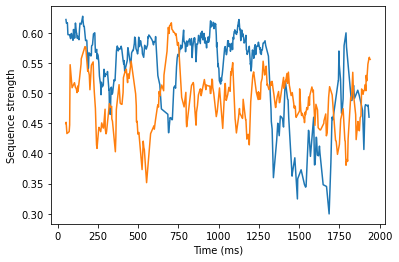

In [68]:
plt.figure()
plt.plot(spike_t_puff, seq_strength_puff)
plt.plot(spike_t_safe, seq_strength_safe)
plt.xlabel('Time (ms)')
plt.ylabel('Sequence strength')
plt.savefig('Lastresultstemporalstuff.svg')
plt.show()